# This is the python codes of my final year projects

In [1]:
# import fundamental libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw,pacf_ols
#AR model
from statsmodels.tsa.ar_model import AR,ARResults
#ARIMA model
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from pandas.plotting import lag_plot
import math
from statsmodels.stats.stattools import durbin_watson
# Ignore harmless warning
import warnings
warnings.filterwarnings("ignore")
# change options to display all outputs
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [2]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series, title = ""):
    """
    時系列を投入し，オプションでタイトルを決めると，ADFレポートを返す
    """
    print(f"Augumented Dickey-Fuller Test:{title}")
    result = adfuller(series.dropna(),autolag = "AIC") # .dropna() handles differenced data
    labels = ["ADS test statistic", "p-value", "# lags used", "# observations"] # # はnumberの略
    out = pd.Series(result[0:4],index = labels)

    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out.to_string()) # .to_string() は "dtype:float64"を取り除く

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    return result[1]

#ここからadfなどもして前期との相関を見てくれる関数を作る
def plot_series(series, figsize = (9,6), title = "", model = "add"):
    season = seasonal_decompose(series,model = model)
    season.plot();

def plot_property(series, title = "", num = 30):
    lag_plot(series)
    plot_acf(series,lags = num, title = f"{title} ACF")
    plot_pacf(series,lags = num,title = f"{title} PACF")


def all_plot(data, title = "", figsize = (20,15),model = "add",series = False, acf = False ,num = 30,col = 2):
    """
    全てのデータをプロットする．オプションでacf, pacfもプロットできるはず
    """
    columns = data.columns
    fig, axes = plt.subplots(nrows= math.ceil(len(columns)/col), ncols=col, dpi=120, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i <= len(columns)-1:
            df = data[data.columns[i]]
            ax.plot(df, linewidth=1)
            ax.set_title(data.columns[i])
#             ax.xaxis.set_ticks_position('none')
#             ax.yaxis.set_ticks_position('none')
#             ax.spines["top"].set_alpha(0)
            ax.tick_params(labelsize=6)
            plt.subplots_adjust(hspace=1)
    if len(columns) % 2 != 0:
        ax.plot([0,0,0,0,0,0,0,0,0,0,0])
    for column in columns:
        if series == True:
            plot_series(data[column],title = column, model = model,figsize = figsize)
        if acf == True:
            plot_property(data[column], title = column, num = num)

#何個のdiffを取るべきかを明らかにする
def auto_adf(data):
    num = len(data.columns)
    #num_dic shows how many times the series need to be differenced
    num_dic = {}
    for x in range(num):
        result = adf_test(data.iloc[:,x])
        diff_num = 0
        series = data.iloc[:,x].diff()
        while result > 0.05:
            result = adf_test(series)
            series = series.diff()
            diff_num = diff_num + 1
        print(f"{data.columns[x]} needs {diff_num} times difference to obtain stationary")
        num_dic[data.columns[x]] = diff_num
        print("--------------------------------")
    return num_dic

#diffを行う回数分差分を取り，それを再びデータとして加える．
def differencing_data(data):
    #make a new data frame, which requires the same index of the original data
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    #辞書型のデータを取る
    dic_data = auto_adf(data)
    num = len(data.columns)
    for x in range(num):
        series = data.iloc[:,x]
        diff_num = dic_data[data.columns[x]]
        diff_times = 0
        while diff_times != diff_num:
            series = series.diff()
            diff_times = diff_times + 1
        #add series to the new_data
        new_data[f"{data.columns[x]}_{diff_num}"] = series
    return new_data.dropna()


#予測の関数を作る,　蜜柑

def ARforecast(original_data,num = 5,order = 6):
    """
    You need to input stationary data.
    The function automatically forecast with AR model.
    You can input DataFrame.
    The function returns the forecasts of variables and their lags in AR models as a dictionary.
    """
    data = differencing_data(original_data).dropna()
    train = data[:-num]
    test = data[-num:]
    lags = {}
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(index = idx,columns = data.columns)
    for key in data.columns:
        result_AIC = {}
        result_BIC = {}
        for i in range(1,order):
            model = AR(train[[key]])
            result = model.fit(i)
            result_AIC[i] = result.aic
            result_BIC[i] = result.bic
        min_AIC = min(result_AIC, key=result_AIC.get)
        min_BIC = min(result_BIC, key = result_BIC.get)
        md = AR(train[key])
        result = md.fit(min_AIC)
        print(result.summary())
        lag_order = result.k_ar
        lags[key] = lag_order
        start = len(train)
        end = len(train) + len(test) - 1
        forecast = result.predict(start = start ,end = end)
        idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
        df_forecast[key] = pd.DataFrame(forecast)
    return df_forecast,lags # return is two variables

#VARforecast関数に投入するtrainデータにはnot positive definiteの列を加えてはならない
#------Q. not positive definiteとなる列をどのように処理するのか？？--------
def VARforecast(data,num = 5,order = 7,orth = True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order+3)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    # Durbin_watsonを組み込んだ
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson Test is ended")
    return df_forecast.dropna()

#granger causalityを調べる関数が必要である．
# original data でgrnger causalityを調べたとして，それはdifferenced dataに対しても有効になるのか？
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test',set_p_value =0.05, verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            #p_values = [test_result[i+1][0][test][1] for i in range(maxlag)]
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            if min_p_value < set_p_value or min_p_value == 1:
                df.loc[r, c] = min_p_value
            else:
                df.loc[r, c] = False
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#共和分のテスト
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary_
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


#二つのデータをプロットして比較してくれる関数
def compare_plot(series1,series2,size = (12,6),title1 = "", title2 = "", legend = True, tight = True):
    """
    二つのデータを同時にプロット
    Plot two data simultaneously
    """
    ax = series1.plot(figsize = size, legend = legend, title = title1)
    ax.autoscale(axis = "x", tight = tight)
    dx = series2.plot(figsize = size, legend = legend, title = title1)
    dx.autoscale(axis = "x", tight = tight)

#基のデータに戻していくプロセスを行う
def reverse_data(original_data, num = 5, order = 7,orth=True):
    """
    VARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast = VARforecast(original_data,num = num,order = order,orth=orth)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna()

def ar_reverse_data(original_data, num = 5, order = 7):
    """
    ARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast,lags = ARforecast(original_data,num = num,order = order)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna(),lags

def VAR_AR_plot_evaluation(data,col = 2,num = 5,order = 7,orth= True):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse_vr = reverse_data(data, num = num,order = order,orth = orth)
    print("reverse_data is executed")
    reverse_ar,lag = ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
#        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    return lag

#プロットして比較する．
def FvsA_plot(data,col = 2,num = 5,order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse = reverse_data(data, num = num,order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)

# Evaluate関数
#予測するための道具を出す．
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def forecast_data(data,col = 2, num = 5, order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = reverse_data(data,num = num,order=order)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")

def Durbin_Watson(data,num = 5,order = 7):
    """
    Durbin_Watson検定を行う．その際には，differencingしたデータでmin AICとなるモデルを選択して当てはめる．
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))



In [3]:
# differencingしないパターンでの関数を作成した
# nodiffではreverseも必要ない
def VARforecast_nodiff(data,num = 5,order = 7,orth= True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson test is ended")
    print("-------------------------------")
    return df_forecast

def VAR_AR_plot_evaluation_nodiff(data,col = 2,num = 5,order = 7,orth=True):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse_vr = VARforecast_nodiff(data, num = num,order = order,orth=orth)
    reverse_ar,lag = ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
#         ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    #return lag

def FvsA_plot_nodiff(data,col = 2,num = 5):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    """
    reverse = VARforecast_nodiff(data, num = num)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax)
        test[col][-num:].plot(legend= True, ax=ax).autoscale(axis='x',tight=True);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} Forecast",f"{col} Actual"])
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
#         ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)


def forecast_data_nodiff(data,col = 2, num = 5):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = VARforecast_nodiff(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")



In [4]:
def one_differencing_data(data):
    #make a new data frame, which requires the same index of the original data
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    #辞書型のデータを取る
    dic_data = auto_adf(data)
    num = len(data.columns)
    for x in range(num):
        series = data.iloc[:,x]
        diff_num = dic_data[data.columns[x]]
        diff_times = 0
        if diff_num != 0:
            series = series.diff()
            diff_times = diff_times + 1
        #add series to the new_data
        new_data[f"{data.columns[x]}_{diff_times}"] = series
    return new_data.dropna()

def ARforecast_onediff(original_data,num = 5,order = 6):
    """
    You need to input stationary data.
    The function automatically forecast with AR model.
    You can input DataFrame.
    The function returns the forecasts of variables and their lags in AR models as a dictionary.
    """
    data = one_differencing_data(original_data)
    train = data[:-num]
    test = data[-num:]
    lags = {}
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(index = idx,columns = data.columns)
    for key in data.columns:
        result_AIC = {}
        result_BIC = {}
        for i in range(1,order):
            model = AR(train[[key]])
            result = model.fit(i)
            result_AIC[i] = result.aic
            result_BIC[i] = result.bic
        min_AIC = min(result_AIC, key=result_AIC.get)
        min_BIC = min(result_BIC, key = result_BIC.get)
        md = AR(train[key])
        result = md.fit(min_AIC)
        print(result.summary())
        lag_order = result.k_ar
        lags[key] = lag_order
        start = len(train)
        end = len(train) + len(test) - 1
        forecast = result.predict(start = start ,end = end)
        idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
        df_forecast[key] = pd.DataFrame(forecast)
    return df_forecast,lags # return is two variables

#VARforecast関数に投入するtrainデータにはnot positive definiteの列を加えてはならない
#------Q. not positive definiteとなる列をどのように処理するのか？？--------
def VARforecast_onediff(data,num = 5,order = 7,orth = True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= one_differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order+3)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    # Durbin_watsonを組み込んだ
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson Test is ended")
    return df_forecast.dropna()

def one_reverse_data(original_data, num = 5, order = 7,orth=True):
    """
    VARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast = VARforecast_onediff(original_data,num = num,order = order,orth=orth)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna()

def one_ar_reverse_data(original_data, num = 5, order = 7):
    """
    ARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast,lags = ARforecast_onediff(original_data,num = num,order = order)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna(),lags

def VAR_AR_plot_evaluation_onediff(data,col = 2,num = 5,order = 7,orth= True):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse_vr = one_reverse_data(data, num = num,order = order,orth = orth)
    print("reverse_data is executed")
    reverse_ar,lag = one_ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
#        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    return lag

In [5]:
def all_compare(data,compare = "S_P500",col = 2,legend = True, tight = True,figsize = (15,15)):
    data = data.dropna()
    compare_series = data[compare]
    data = data.drop(compare,axis = 1)
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=figsize)
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        data[col].plot(legend=legend, ax=ax)
        compare_series.plot(legend=legend, ax=ax).autoscale(axis='x',tight=tight);
        #plt.legend(fontsize=16, loc='upper right')
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col}",f"{compare}"],fontsize=5, loc='upper left')
        plt.subplots_adjust(hspace=2)
    for i in range(len(data.columns)):
        prod = forecast_accuracy(data[data.columns[i]].values,compare_series)#valueはなくていいのか？
        print(f"Compare {data.columns[i]} with {compare} Mathmatically")
        for k, v in prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")



In [6]:
# These functions are bulit to meet the criteria of FRED-MD.
def adjust_data(data,dic):
    """
    Create a function to change data based on tranformation code and return a new dataframe.
    The transformation code is obtained from FRED-MD.
    THe meaning of transformation code is written below
    (1) no transformation
    (2) delta x_t
    (3) delta^2 x_t
    (4) log(x_t)
    (5) delta(log(x_t))
    (6) delta^2(log(x_t))
    (7)delta(x_t/x_{t-1} - 1)
    """
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx,columns = [k for k in dic.keys()])
    # change the data at each column, and add it to the new dataframe
    for key, val in dic.items():
        # if the code is 1, no transformation is required
        if val == 1:
            new_data[key] = data[[key]]
    
        # if the code is 2, the data needs one differentiation
        if val == 2:
            new_data[key] = data[[key]].diff()

        # if the code is 3, the data needs differentiation twice
        if val == 3:
            new_data[key] = data[[key]].diff().diff()

        # if the code is 4, the data needs to take its logarithm
        if val == 4:
            new_data[key] = data[[key]].apply(np.log)

        # if the code is 5, the data needs to take its logarithm and differntiation once
        if val == 5:
            new_data[key] = data[[key]].apply(np.log).diff()
          
        # if the code is 6, the data needs to take its rogarithm and differentiation twice
        if val == 6:
            new_data[key] = data[[key]].apply(np.log).diff().diff()
        
        # if the code is 7, the data needs to be divided by its lag-1 value and minus one, and then take its differentiation
        if val == 7:
            new_data[key] = data[[key]].dropna().pct_change().diff()
    return new_data.dropna()

# ARmode
def ARmodel(data,dic,num = 5,order = 6):
    """
    You need to input stationary data.
    The function automatically forecast with AR model.
    You can input DataFrame.
    The function returns the forecasts of variables and their lags in AR models as a dictionary.
    """
    train = data[:-num]
    test = data[-num:]    
    lags = {}
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(index = idx,columns = data.columns)
    for key in dic.keys():
        result_AIC = {}
        result_BIC = {}
        for i in range(1,order):
            model = AR(train[[key]])
            result = model.fit(i)
            result_AIC[i] = result.aic
            result_BIC[i] = result.bic
        min_AIC = min(result_AIC, key=result_AIC.get)
        min_BIC = min(result_BIC, key = result_BIC.get)
        md = AR(train[key])
        result = md.fit(min_AIC)
        print(result.summary())
        lag_order = result.k_ar
        lags[key] = lag_order
        start = len(train)
        end = len(train) + len(test) - 1
        forecast = result.predict(start = start ,end = end)
        idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
        df_forecast[key] = pd.DataFrame(forecast)
    return df_forecast,lags # return is two variables

# Predict the future with VAR model
def VARmodel(data,dic,num = 5,order = 7,orth = True,figsize =(11,11)):
    """
    Here, we aim to forecast the future values of selected variables.
    This function connects to adjust_data function.
    Do not confuse with VARforecast, which uses diff_data function.
    VARforecast does not depend on FRED-MD
    You need to input stationary data.
    If you choose orth = True, the orthogonal impulse respnse is plotted 
    """
    train = data[:-num]
    test = data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order)
    irf.plot(orth=orth)
    #irf.set_size_inches(12,8)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("-------------Durbin Watson test is ended------------------")
    return df_forecast.dropna()

# This function reverse the stationary data to the original scale
def revert_forecast(original_data,forecast,dic,num = 5,order = 7):
    """
    This function aims to reverse the forecasted data to the original one.
    The function requires the transformation code as well
    (1) no transformation
    (2) delta x_t
    (3) delta^2 x_t
    (4) log(x_t)
    (5) delta(log(x_t))
    (6) delta^2(log(x_t))
    (7)delta(x_t/x_{t-1} - 1)
    """
    idx = pd.date_range(forecast.index[0],periods = len(forecast.index),freq = forecast.index.freq)
    new_data = pd.DataFrame(index = idx,columns = [k for k in dic.keys()])
    diff_data = pd.DataFrame(index = idx,columns = [k for k in dic.keys()])
    for key, val in dic.items():
        # if the code is 1, no transformation is required
        if val == 1:
            new_data[key] = forecast[key]
        # if the code is 2, the data needs one differentiation
        if val == 2:
            new_data[key] = original_data[key].iloc[-num-1] + forecast[key].cumsum()
        # if the code is 3, the data needs differentiation twice
        if val == 3:
            diff_data[key] = original_data[key].iloc[-num-1] - original_data[key].iloc[-num-2]+forecast.cumsum()
            new_data[key] = original_data[key].iloc[-num-1] + diff_data[key].cumsum()
    
        # if the code is 4, the data needs to take its logarithm
        if val == 4:
            new_data[key] = forecast[key].apply(math.exp)
        # if the code is 5, the data needs to take its logarithm and differntiation once
        if val == 5:
            diff_data[key] = np.log(original_data[key].iloc[-num-1]) + forecast[key].cumsum()
            new_data[key] = diff_data[key].apply(math.exp)
        
        # if the code is 6, the data needs to take its rogarithm and differentiation twice
        if val == 6:
            diff_data[key] = np.log(original_data[key].iloc[-num-1]) - np.log(original_data[key].iloc[-num-2]) + forecast[key].cumsum()
            new_data[key] = np.log(original_data[key].iloc[-num-1]) + diff_data[key].cumsum()
            new_data[key] = new_data[key].apply(math.exp)
        
        # if the code is 7, the data needs to be divided by its lag-1 value and minus one, and then take its differentiation
        if val == 7:
            diff_data[key] = original_data[key].pct_change()[-num-1] + forecast[key][-num:].cumsum()
            for i in range(num):
                if i == 0:
                    new_data[key][i] = (1+diff_data[key][i])*original_data[key][-num-1]
                else:
                    new_data[key][i] = (1+diff_data[key][i])*new_data[key][i-1]        
            new_data[key] = data[key].dropna().pct_change().diff()
    return new_data.dropna()

# Plot and Evaluation
def forecast_evaluation(forecast, actual):
    """
    This function prepares the evaluation of forecast.
    """
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def evaluate_plot(data,dic,col = 2,num = 5,order = 7,test = 'ssr_chi2test',verbose = False):
    """
    Plot the data to compare the forecast with the actual data.
    This function just requres the original data as an input
    because this function combines with the reverse_data function.
    The function also evaluates the model at the same time
    """
    test = data.dropna()[-num:]
    # change the data to stationary
    df = adjust_data(data,dic)
    # make a list of keys in the dictionary
    keys = [k for k in dic.keys()]
    # set the figure size in accordance with the number of keys
    figsize = (len(keys)*2.5,len(keys)*2.5)
    # Check Granger Causality
    #grangers_causation_matrix(df[keys].dropna(),variables = keys, test = test, verbose = verbose)
    # predict the future with AR model and VAR model
    ar,lag = ARmodel(df,dic,num = num,order = order)
    var = VARmodel(df,dic,num = num,order = 7,figsize = figsize)
    # reverse the data to the original scale
    ar_reverse = revert_forecast(data,ar,dic,num = num,order = order)
    var_reverse = revert_forecast(data,var,dic,num = num, order = order)
    # plot part
    fig, axes = plt.subplots(nrows= math.ceil(len(keys)/col), ncols= col, dpi=150, figsize=figsize)
    for i, (col,ax) in enumerate(zip(keys, axes.flatten())):
        ar_reverse[keys[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        var_reverse[keys[i]].plot(legend = True, ax = ax)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} AR Forecast",f"{col} VAR Forecast",f"{col} Actual"])
        #ax.xaxis.set_ticks_position('none')
        #ax.yaxis.set_ticks_position('none')
        #ax.spines["top"].set_alpha(0)
        #ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    # evaluation part
    for i in range(len(keys)):
        print(f"{keys[i]} AR Accuracy")
        accuracy_prod = forecast_evaluation(ar_reverse[keys[i]].values,test[keys[i]])#valueはなくていいのか？
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        print(f"{keys[i]} VAR Accuracy")
        accuracy_prod = forecast_evaluation(var_reverse[keys[i]].values,test[keys[i]])#valueはなくていいのか？
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    return lag # returns the list of the AR lags for each variable.

def coin_evaluate_plot(data,dic,col = 2,num = 5,order = 7,test = 'ssr_chi2test',verbose = False):
    """
    Plot the data to compare the forecast with the actual data.
    This function just requres the original data as an input.
    However! the veriables should be cointegrated.
    because this function combines with the reverse_data function.
    The function also evaluates the model at the same time
    """
    test = data.dropna()[-num:]
    # change the data to stationary
    df = data.copy()
    # make a list of keys in the dictionary
    keys = [k for k in dic.keys()]
    # set the figure size in accordance with the number of keys
    figsize = (len(keys)*2.5,len(keys)*2.5)
    # Check Granger Causality
    #grangers_causation_matrix(df[keys].dropna(),variables = keys, test = test, verbose = verbose)
    # predict the future with AR model and VAR model
    ar,lag = ARmodel(df,dic,num = num,order = order)
    var = VARmodel(df,dic,num = num,order = 7,figsize = figsize)
    # no need to reverse the data to the original scale
    ar_reverse = ar
    var_reverse = var
    # plot part
    fig, axes = plt.subplots(nrows= math.ceil(len(keys)/col), ncols= col, dpi=150, figsize=figsize)
    for i, (col,ax) in enumerate(zip(keys, axes.flatten())):
        var_reverse[keys[i]].plot(legend = True, ax = ax)
        ar_reverse[keys[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
        #ax.xaxis.set_ticks_position('none')
        #ax.yaxis.set_ticks_position('none')
        #ax.spines["top"].set_alpha(0)
        #ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    # evaluation part
    for i in range(len(keys)):
        print(f"{keys[i]} VAR Accuracy")
        accuracy_prod = forecast_evaluation(var_reverse[keys[i]].values,test[keys[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        print(f"{keys[i]} AR Accuracy")
        accuracy_prod = forecast_evaluation(ar_reverse[keys[i]].values,test[keys[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    return lag # returns the list of the AR lags for each variable.




In [7]:
# This is the yearly data of the U.S.A
usa = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/yearly_usa_data.csv",index_col= 0,header = 1, parse_dates = True)
usa.index.freq = "YS"
df_usa = differencing_data(usa.dropna())
onediff_usa = one_differencing_data(usa.dropna())

Augumented Dickey-Fuller Test:
ADS test statistic      -0.945156
p-value                  0.772739
# lags used              6.000000
# observations          31.000000
Critical Value (1%)     -3.661429
Critical Value (5%)     -2.960525
Critical Value (10%)    -2.619319
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -1.767919
p-value                  0.396501
# lags used              5.000000
# observations          31.000000
Critical Value (1%)     -3.661429
Critical Value (5%)     -2.960525
Critical Value (10%)    -2.619319
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic     -7.690756e+00
p-value                 1.421393e-11
# lags used             4.000000e+00
# observations          3.100000e+01
Critical Value (1%)    -3.661429e+00
Critic

In [8]:
# Figure 1
granger = ["S&P500_2","ST(G%)_0",'TRADE(T)_2','GDP_1','RGDP_1','GDP(G%)_0','WP(M)_1','R&D(T)_1','ISS_1']
grangers_causation_matrix(df_usa[granger].dropna(),variables=df_usa[granger].columns)

S&P500_2_x ST(G%)_0_x  TRADE(T)_2_x  GDP_1_x  RGDP_1_x  \
S&P500_2_y           1.0          0         0.017   0.0000    0.0000   
ST(G%)_0_y           0.0          1         0.000   0.0000    0.0000   
TRADE(T)_2_y         0.0          0         1.000   0.0000    0.0000   
GDP_1_y              0.0          0         0.000   1.0000    0.0041   
RGDP_1_y             0.0          0         0.000   0.0000    1.0000   
GDP(G%)_0_y          0.0          0         0.000   0.0000    0.0000   
WP(M)_1_y            0.0          0         0.000   0.0000    0.0000   
R&D(T)_1_y           0.0          0         0.000   0.0000    0.0000   
ISS_1_y              0.0      False         0.000   0.0004    0.0069   

              GDP(G%)_0_x  WP(M)_1_x  R&D(T)_1_x  ISS_1_x  
S&P500_2_y         0.0000      0.000      0.0000   0.0000  
ST(G%)_0_y         0.0000      0.000      0.0000   0.0059  
TRADE(T)_2_y       0.0000      0.000      0.0000   0.0000  
GDP_1_y            0.0000      0.000      0.0000   0.0000  
RGDP_1_y           0.0000      0.000      0.0000   0.0000  
GDP(G%)_0_y        1.0000      0.001      0.0000   0.0083  
WP(M)_1_y          0.0351      1.000      0.0000   0.0000  
R&D(T)_1_y         0.0000      0.000      1.0000   0.0000  
ISS_1_y            0.0078      0.000      0.0049   1.0000

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
BCP(%) ::  78.26     > 40.1749   =>   True
GCE(%) ::  31.64     > 24.2761   =>   True
GDP    ::  15.51     > 12.3212   =>   True
S&P500 ::  4.25      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:12:16
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    19.3625
Nobs:                     38.0000    HQIC:                   16.5863
Log likelihood:          -401.686    FPE:                9.84635e+06
AIC:                      15.0530    Det(Omega_mle):     1.30331e+06
--------------------------------------------------------------------
Results for equation BCP(%)
               coefficient       std. error           t-stat            prob
--------------------

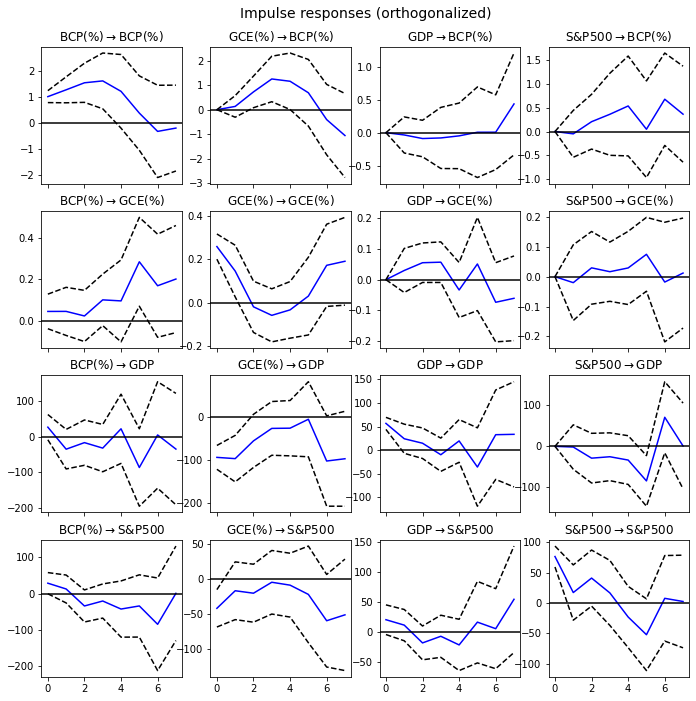

The function plots the Forecast Error Variance Decomposition
FEVD for BCP(%)
       BCP(%)    GCE(%)       GDP    S&P500
0    1.000000  0.000000  0.000000  0.000000
1    0.991931  0.006751  0.000447  0.000871
2    0.893232  0.097250  0.001621  0.007898
3    0.767492  0.213445  0.001561  0.017502
4    0.697642  0.265889  0.001369  0.035100

FEVD for GCE(%)
       BCP(%)    GCE(%)       GDP    S&P500
0    0.031701  0.968299  0.000000  0.000000
1    0.046933  0.939205  0.009558  0.004305
2    0.050983  0.896220  0.039900  0.012896
3    0.133399  0.791465  0.061805  0.013331
4    0.193909  0.722977  0.064480  0.018634

FEVD for GDP
       BCP(%)    GCE(%)       GDP    S&P500
0    0.056699  0.688861  0.254439  0.000000
1    0.081246  0.758207  0.160422  0.000125
2    0.078319  0.748618  0.143277  0.029786
3    0.105187  0.711347  0.134907  0.048559
4    0.111608  0.674160  0.135702  0.078530

FEVD for S&P500
       BCP(%)    GCE(%)       GDP    S&P500
0    0.091493  0.200567  0.044910  0.66

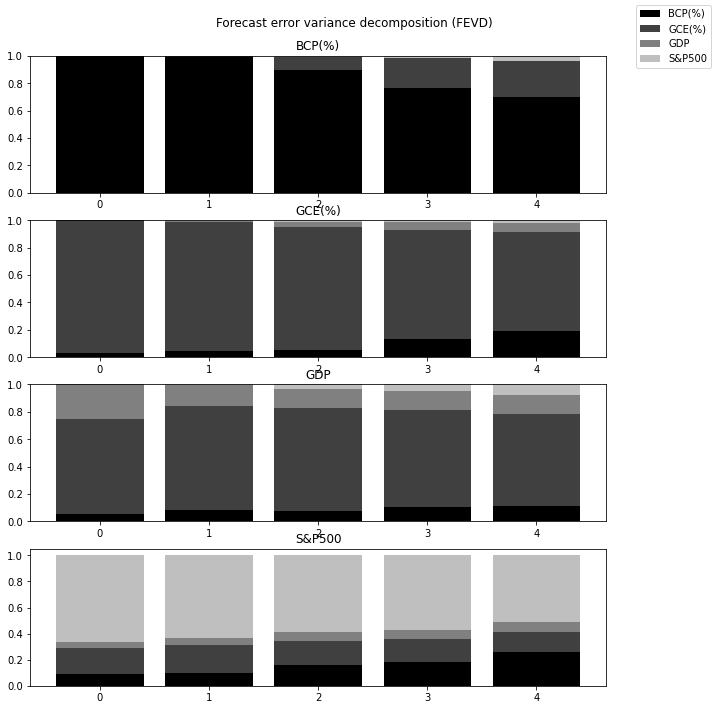

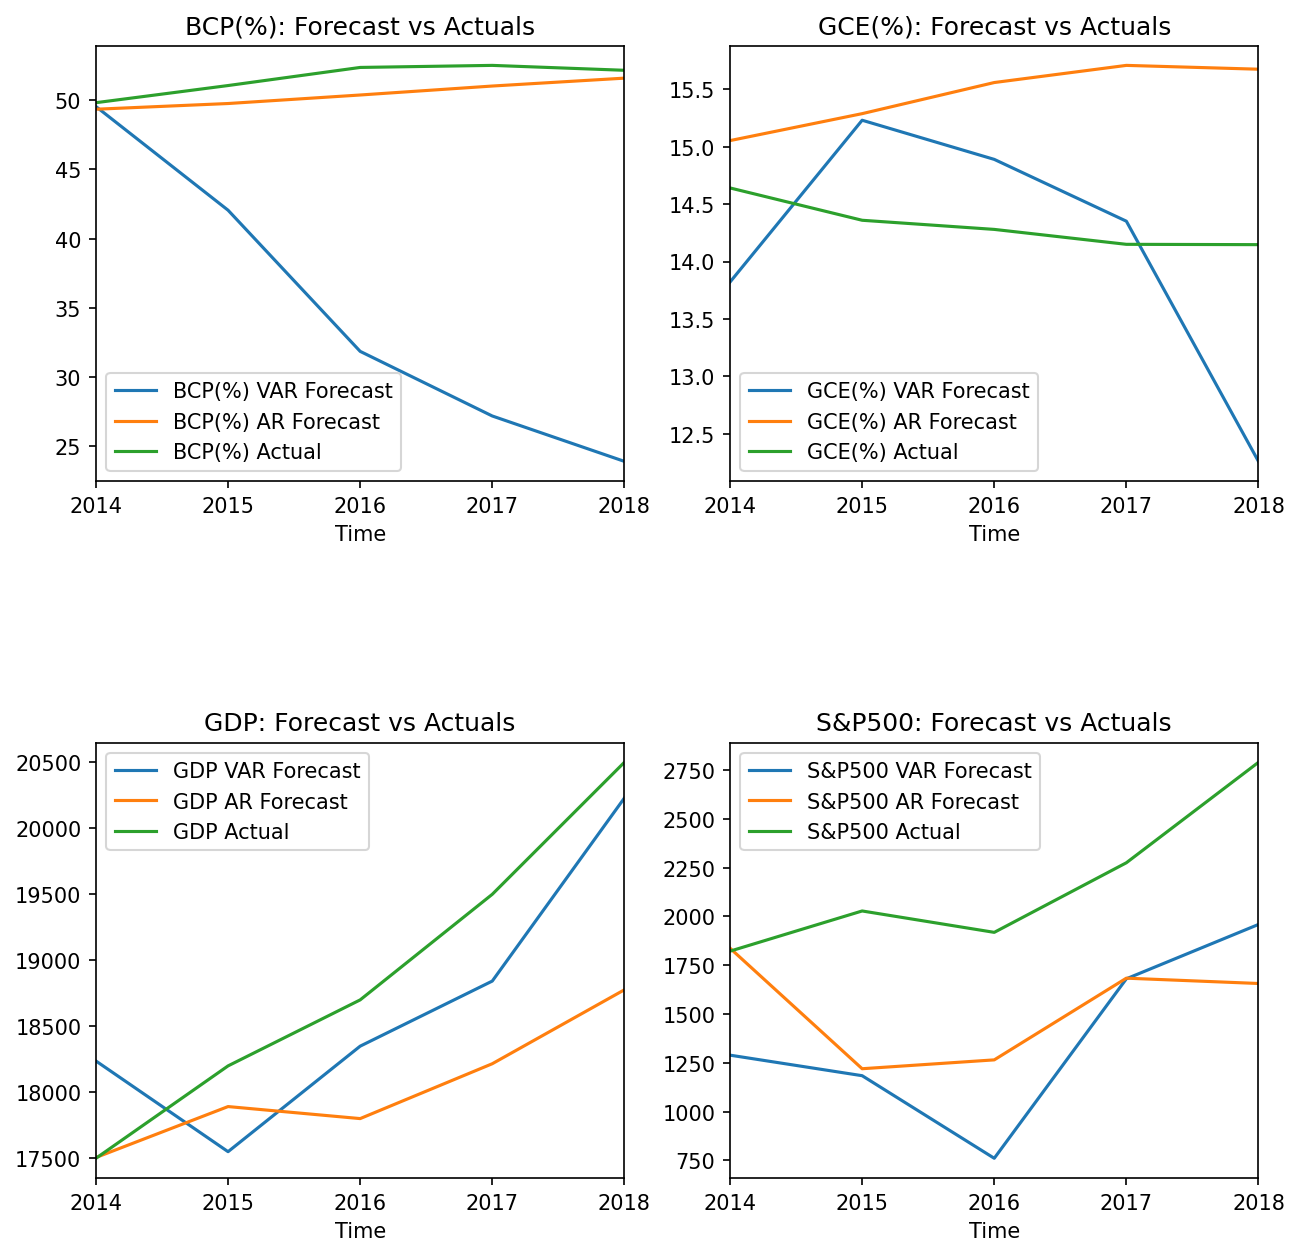

In [9]:
# Figures 2 and 3
variables1 = ["BCP(%)","GCE(%)","GDP","S&P500"]
cointegration_test(usa[variables1].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables1].dropna())

In [10]:
#Figure 4
granger = ["S&P500_1","ST(G%)_0",'TRADE(T)_1','GDP_1','RGDP_1','GDP(G%)_0','WP(M)_1','R&D(T)_1','ISS_1']
grangers_causation_matrix(onediff_usa[granger].dropna(),variables=onediff_usa[granger].columns)

S&P500_1_x ST(G%)_0_x  TRADE(T)_1_x  GDP_1_x  RGDP_1_x  \
S&P500_1_y           1.0     0.0192        0.0171   0.0075    0.0008   
ST(G%)_0_y           0.0          1        0.0000   0.0000    0.0000   
TRADE(T)_1_y         0.0     0.0046        1.0000   0.0000    0.0000   
GDP_1_y              0.0          0        0.0000   1.0000    0.0015   
RGDP_1_y             0.0          0        0.0000   0.0000    1.0000   
GDP(G%)_0_y          0.0          0        0.0000   0.0000    0.0000   
WP(M)_1_y            0.0          0        0.0000   0.0000    0.0000   
R&D(T)_1_y           0.0          0        0.0000   0.0000    0.0000   
ISS_1_y              0.0      False        0.0000   0.0000    0.0026   

              GDP(G%)_0_x  WP(M)_1_x  R&D(T)_1_x  ISS_1_x  
S&P500_1_y         0.0057     0.0055      0.0000   0.0004  
ST(G%)_0_y         0.0000     0.0000      0.0000   0.0003  
TRADE(T)_1_y       0.0147     0.0012      0.0054   0.0000  
GDP_1_y            0.0000     0.0000      0.0000   0.0000  
RGDP_1_y           0.0000     0.0000      0.0000   0.0032  
GDP(G%)_0_y        1.0000     0.0014      0.0000   0.0094  
WP(M)_1_y          0.0403     1.0000      0.0000   0.0001  
R&D(T)_1_y         0.0000     0.0000      1.0000   0.0000  
ISS_1_y            0.0036     0.0005      0.0025   1.0000

In [11]:
# an additional check for Figure 4 
granger = ["S&P500_2","ST(G%)_0",'TRADE(T)_2','GDP_1','RGDP_1','GDP(G%)_0','WP(M)_1','R&D(T)_1','ISS_1']
grangers_causation_matrix(df_usa[granger].dropna(),variables=df_usa[granger].columns)

S&P500_2_x ST(G%)_0_x  TRADE(T)_2_x  GDP_1_x  RGDP_1_x  \
S&P500_2_y           1.0          0         0.017   0.0000    0.0000   
ST(G%)_0_y           0.0          1         0.000   0.0000    0.0000   
TRADE(T)_2_y         0.0          0         1.000   0.0000    0.0000   
GDP_1_y              0.0          0         0.000   1.0000    0.0041   
RGDP_1_y             0.0          0         0.000   0.0000    1.0000   
GDP(G%)_0_y          0.0          0         0.000   0.0000    0.0000   
WP(M)_1_y            0.0          0         0.000   0.0000    0.0000   
R&D(T)_1_y           0.0          0         0.000   0.0000    0.0000   
ISS_1_y              0.0      False         0.000   0.0004    0.0069   

              GDP(G%)_0_x  WP(M)_1_x  R&D(T)_1_x  ISS_1_x  
S&P500_2_y         0.0000      0.000      0.0000   0.0000  
ST(G%)_0_y         0.0000      0.000      0.0000   0.0059  
TRADE(T)_2_y       0.0000      0.000      0.0000   0.0000  
GDP_1_y            0.0000      0.000      0.0000   0.0000  
RGDP_1_y           0.0000      0.000      0.0000   0.0000  
GDP(G%)_0_y        1.0000      0.001      0.0000   0.0083  
WP(M)_1_y          0.0351      1.000      0.0000   0.0000  
R&D(T)_1_y         0.0000      0.000      1.0000   0.0000  
ISS_1_y            0.0078      0.000      0.0049   1.0000

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
WP(M)  ::  165.33    > 60.0627   =>   True
ST(G%) ::  94.85     > 40.1749   =>   True
TRADE(T) ::  47.65     > 24.2761   =>   True
GDP    ::  21.09     > 12.3212   =>   True
S&P500 ::  7.36      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:12:27
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    30.5855
Nobs:                     37.0000    HQIC:                   26.2162
Log likelihood:          -548.490    FPE:                9.66998e+11
AIC:                      23.8371    Det(Omega_mle):     4.61200e+10
--------------------------------------------------------------------
Results for equation WP(M)
                 coefficient       std. error        

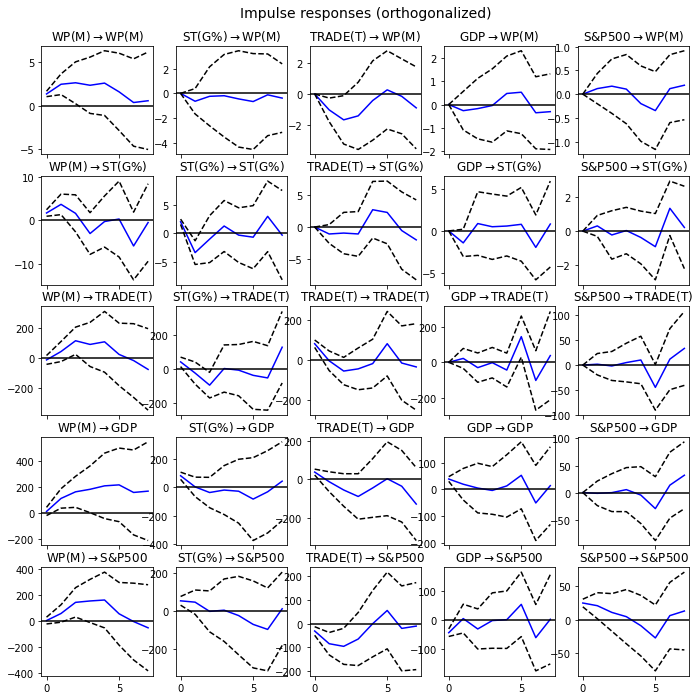

The function plots the Forecast Error Variance Decomposition
FEVD for WP(M)
        WP(M)    ST(G%)  TRADE(T)       GDP    S&P500
0    1.000000  0.000000  0.000000  0.000000  0.000000
1    0.841194  0.041715  0.108318  0.007338  0.001434
2    0.775589  0.023305  0.193755  0.005191  0.002160
3    0.764614  0.018046  0.211572  0.003800  0.001968
4    0.797184  0.019810  0.170781  0.009537  0.002689

FEVD for ST(G%)
        WP(M)    ST(G%)  TRADE(T)       GDP    S&P500
0    0.401360  0.598640  0.000000  0.000000  0.000000
1    0.466367  0.438755  0.033885  0.058297  0.002696
2    0.468254  0.406348  0.051718  0.070081  0.003599
3    0.538008  0.339934  0.061409  0.057897  0.002752
4    0.468890  0.296632  0.173921  0.055888  0.004668

FEVD for TRADE(T)
        WP(M)    ST(G%)  TRADE(T)       GDP    S&P500
0    0.017419  0.215510  0.767071  0.000000  0.000000
1    0.182029  0.205688  0.570110  0.041924  0.000249
2    0.413209  0.296644  0.253461  0.036519  0.000167
3    0.498455  0.232919 

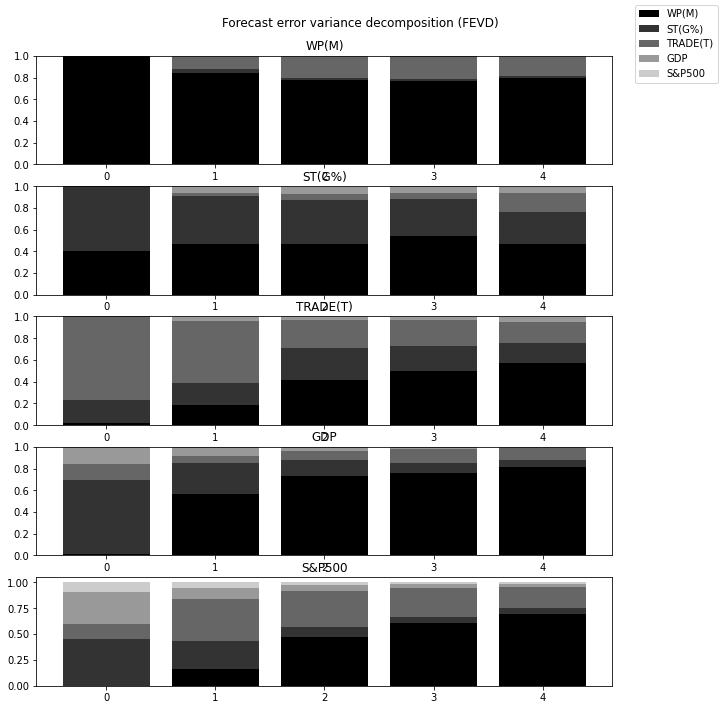

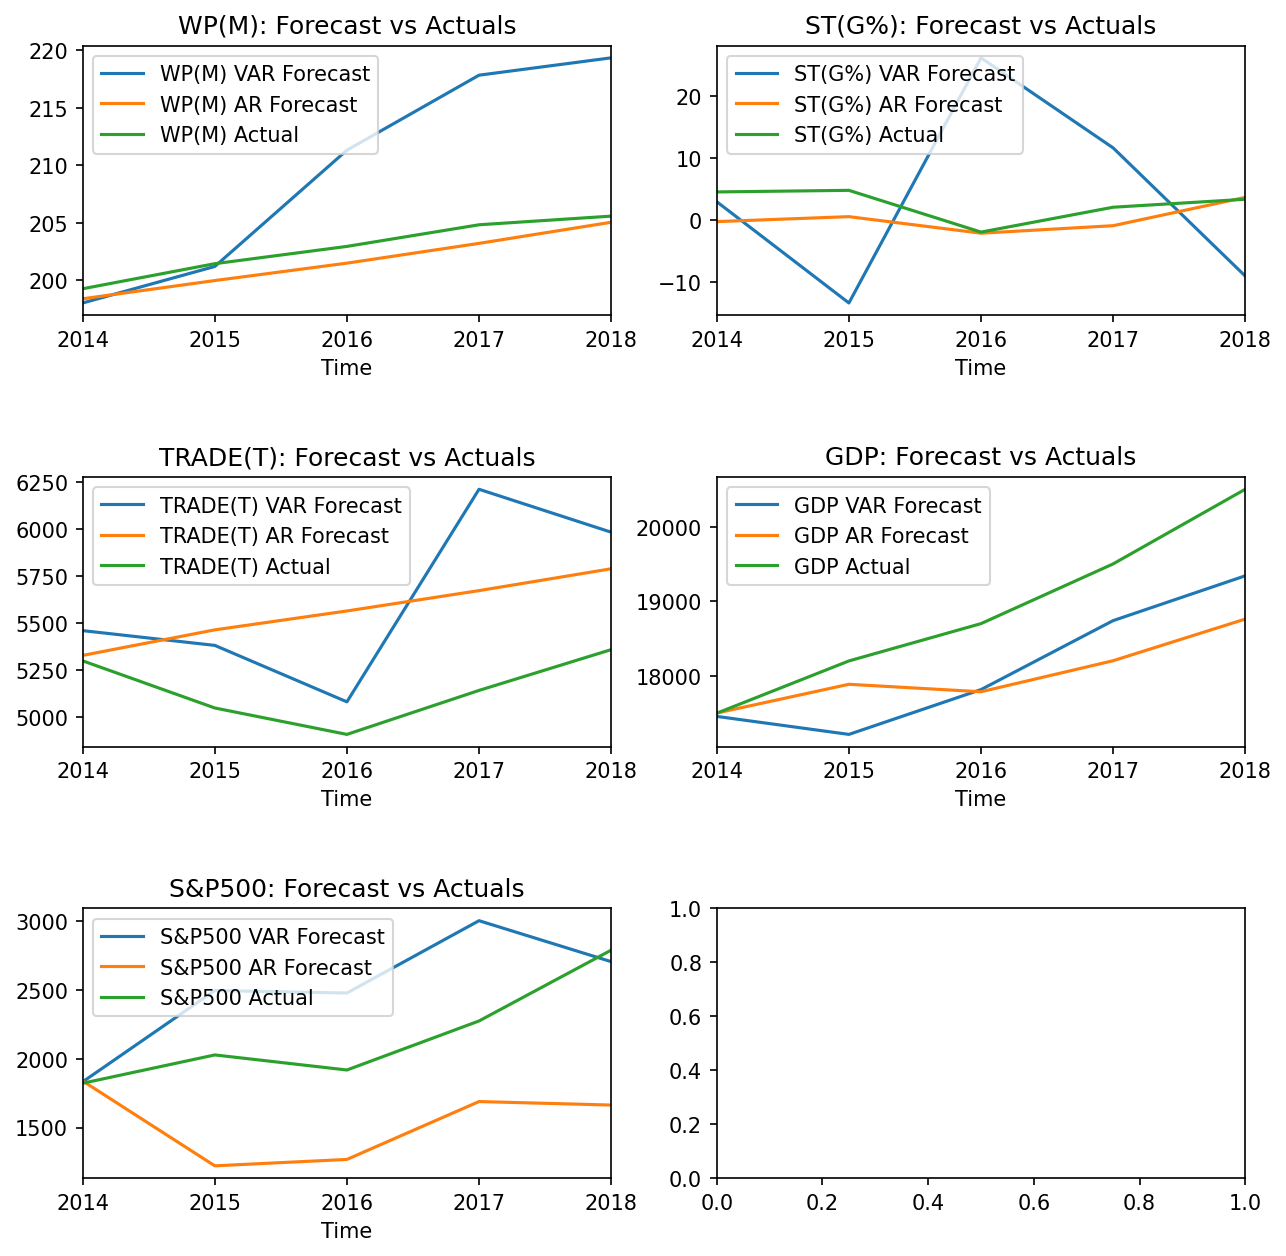

In [12]:
# Figure 5,7, and 9
variables2 = ["WP(M)","ST(G%)","TRADE(T)","GDP","S&P500"]
cointegration_test(usa[variables2].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables2].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
POP(TM) ::  229.58    > 60.0627   =>   True
ST(G%) ::  128.01    > 40.1749   =>   True
TRADE(T) ::  65.17     > 24.2761   =>   True
GDP    ::  37.13     > 12.3212   =>   True
S&P500 ::  12.68     > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:12:35
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    28.3258
Nobs:                     37.0000    HQIC:                   23.9565
Log likelihood:          -506.685    FPE:                1.00935e+11
AIC:                      21.5774    Det(Omega_mle):     4.81399e+09
--------------------------------------------------------------------
Results for equation POP(TM)
                 coefficient       std. error     

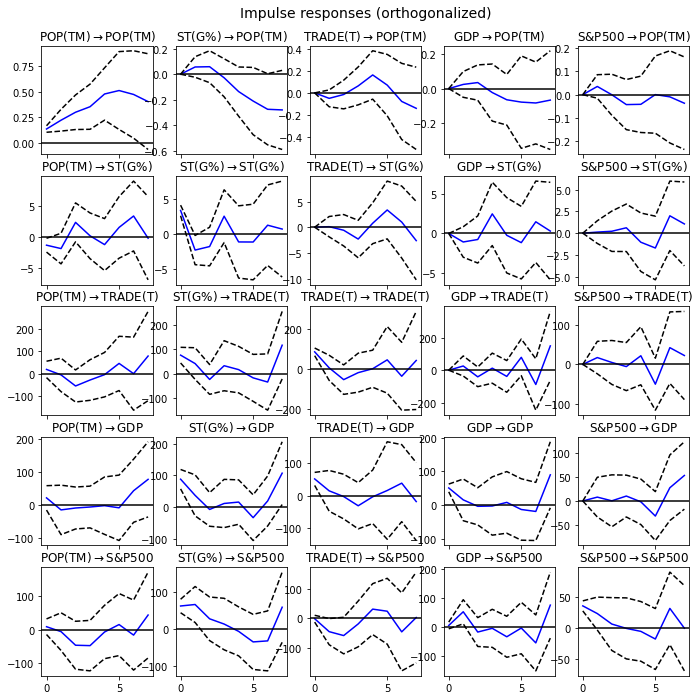

The function plots the Forecast Error Variance Decomposition
FEVD for POP(TM)
      POP(TM)    ST(G%)  TRADE(T)       GDP    S&P500
0    1.000000  0.000000  0.000000  0.000000  0.000000
1    0.901949  0.041758  0.032384  0.007785  0.016125
2    0.927760  0.038635  0.015725  0.010693  0.007187
3    0.935595  0.024367  0.022232  0.007784  0.010023
4    0.878601  0.044307  0.057569  0.011347  0.008176

FEVD for ST(G%)
      POP(TM)    ST(G%)  TRADE(T)       GDP    S&P500
0    0.143868  0.856132  0.000000  0.000000  0.000000
1    0.237339  0.710749  0.000464  0.050762  0.000685
2    0.331592  0.601855  0.010951  0.053620  0.001982
3    0.213852  0.510323  0.110406  0.156657  0.008762
4    0.224703  0.491901  0.111833  0.144481  0.027081

FEVD for TRADE(T)
      POP(TM)    ST(G%)  TRADE(T)       GDP    S&P500
0    0.025902  0.435836  0.538262  0.000000  0.000000
1    0.023763  0.467699  0.446757  0.042522  0.019259
2    0.143178  0.329530  0.416650  0.097027  0.013615
3    0.161252  0.33804

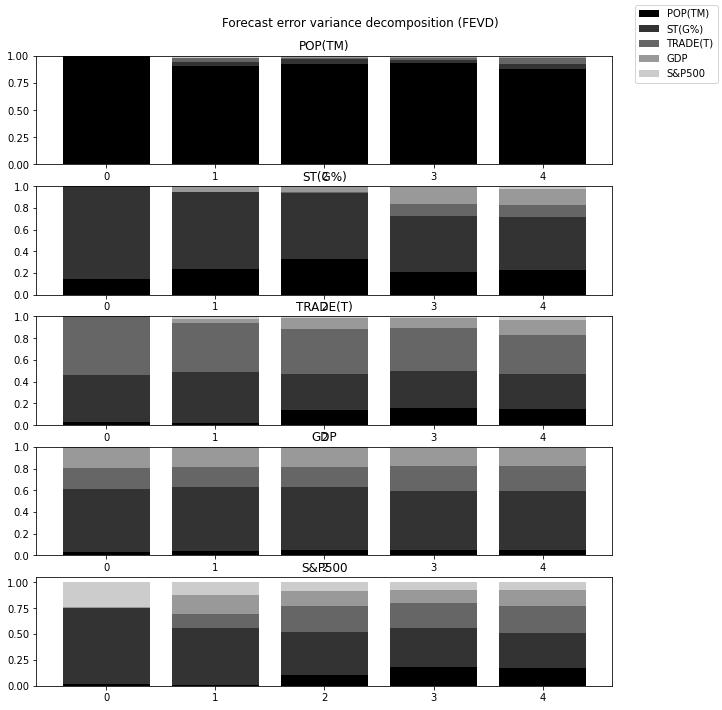

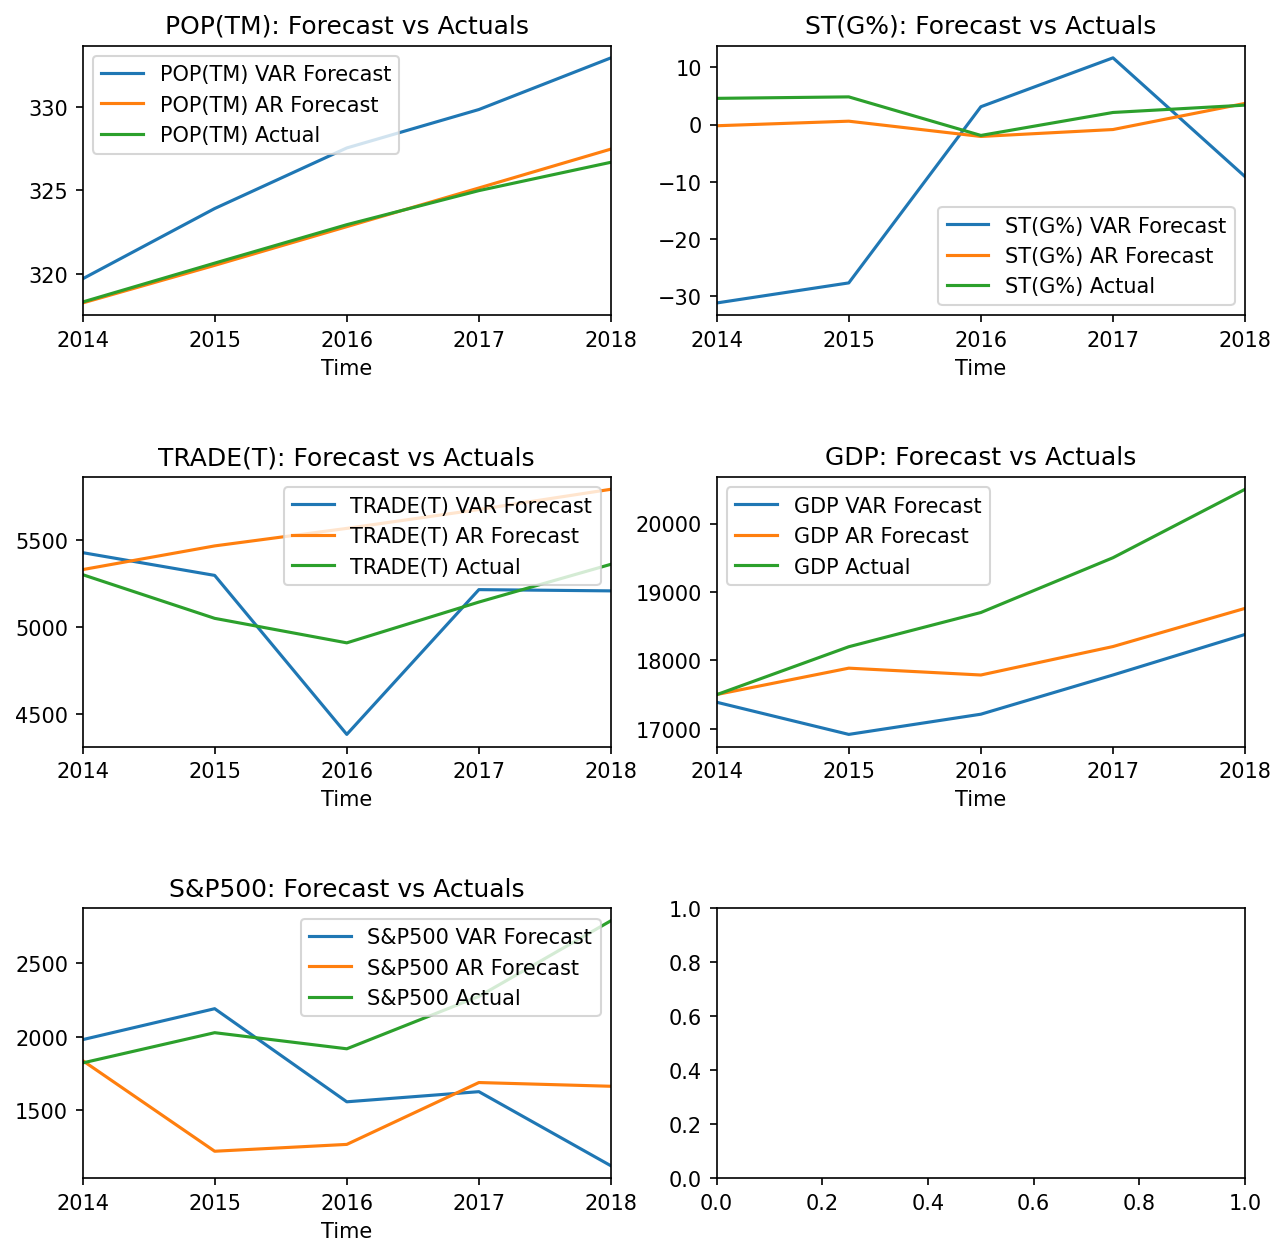

In [13]:
# Figure 6,8, and 10
variables3 = ["POP(TM)","ST(G%)","TRADE(T)","GDP","S&P500"]
cointegration_test(usa[variables3].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables3].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
POP(1564M) ::  201.67    > 60.0627   =>   True
ST(G%) ::  117.84    > 40.1749   =>   True
TRADE(T) ::  72.03     > 24.2761   =>   True
GDP    ::  34.38     > 12.3212   =>   True
S&P500 ::  9.86      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:12:43
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    28.1087
Nobs:                     37.0000    HQIC:                   23.7394
Log likelihood:          -502.668    FPE:                8.12342e+10
AIC:                      21.3602    Det(Omega_mle):     3.87439e+09
--------------------------------------------------------------------
Results for equation POP(1564M)
                   coefficient       std. er

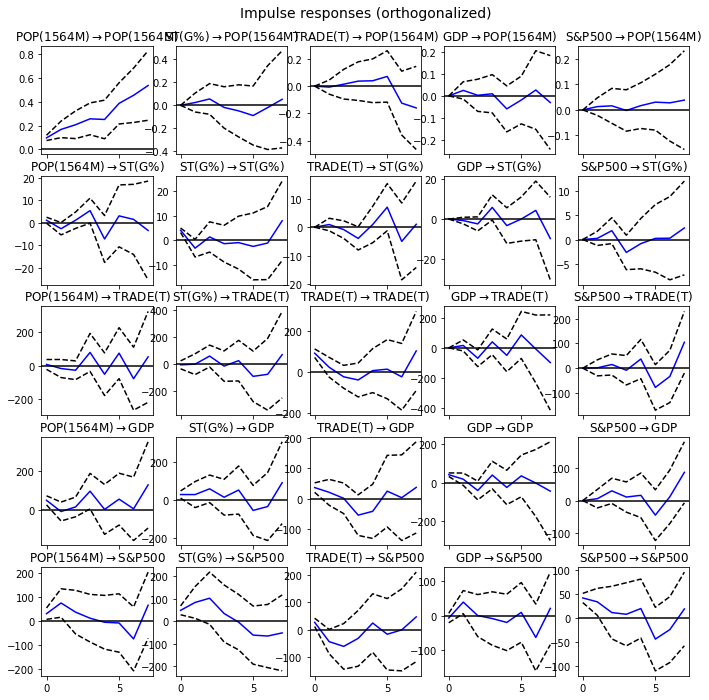

The function plots the Forecast Error Variance Decomposition
FEVD for POP(1564M)
     POP(1564M)    ST(G%)  TRADE(T)       GDP    S&P500
0      1.000000  0.000000  0.000000  0.000000  0.000000
1      0.963576  0.014933  0.001382  0.015784  0.004326
2      0.942214  0.042597  0.002890  0.007311  0.004988
3      0.956195  0.026017  0.010267  0.004703  0.002818
4      0.936381  0.028134  0.013830  0.018461  0.003194

FEVD for ST(G%)
     POP(1564M)    ST(G%)  TRADE(T)       GDP    S&P500
0      0.061864  0.938136  0.000000  0.000000  0.000000
1      0.234274  0.724072  0.024481  0.015620  0.001554
2      0.195431  0.574045  0.031915  0.129709  0.068900
3      0.276732  0.223967  0.125654  0.296000  0.077647
4      0.449509  0.154947  0.088799  0.251118  0.055626

FEVD for TRADE(T)
     POP(1564M)    ST(G%)  TRADE(T)       GDP    S&P500
0      0.005134  0.001767  0.993099  0.000000  0.000000
1      0.038718  0.001690  0.932205  0.027195  0.000192
2      0.060275  0.191966  0.484342  0.2520

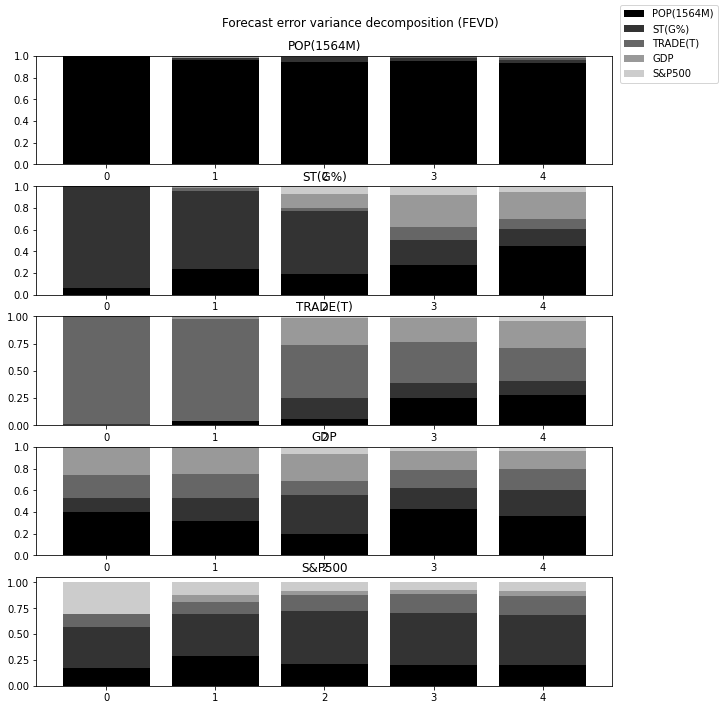

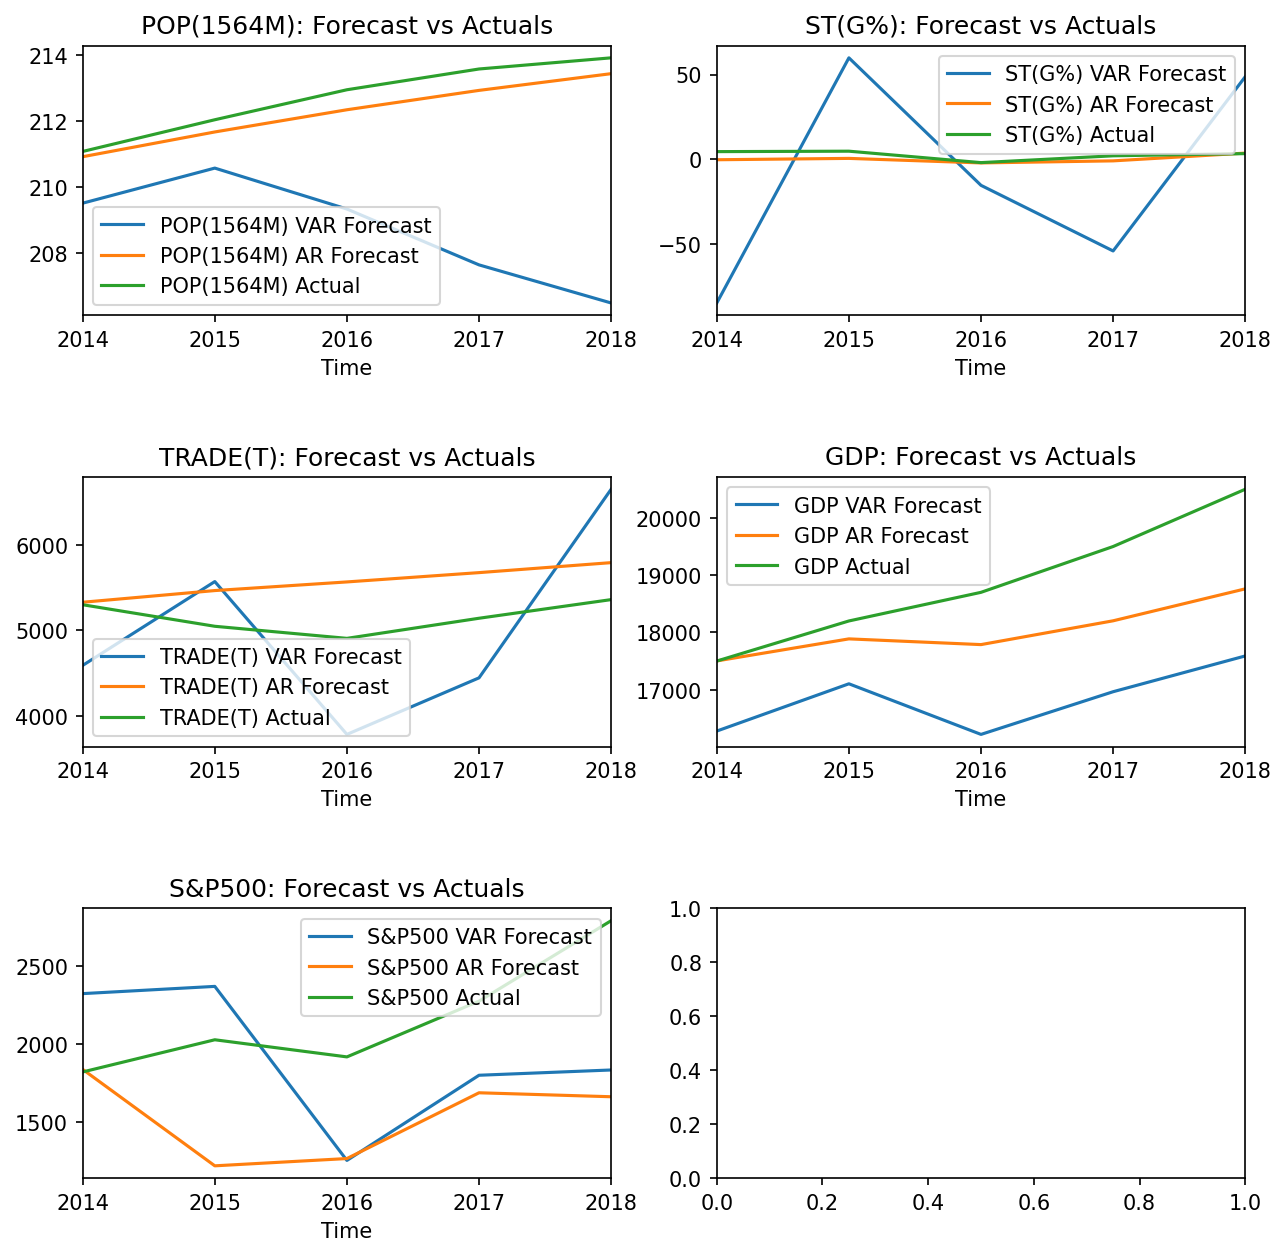

In [14]:
# Figure 11
variables4 = ["POP(1564M)","ST(G%)","TRADE(T)","GDP","S&P500"]
cointegration_test(usa[variables4].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables4].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
WP(M)  ::  179.54    > 60.0627   =>   True
ST(G%) ::  112.72    > 40.1749   =>   True
TRADE(%) ::  48.38     > 24.2761   =>   True
GDP    ::  20.63     > 12.3212   =>   True
S&P500 ::  6.62      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:12:53
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    21.9640
Nobs:                     37.0000    HQIC:                   17.5947
Log likelihood:          -388.992    FPE:                1.74240e+08
AIC:                      15.2156    Det(Omega_mle):     8.31019e+06
--------------------------------------------------------------------
Results for equation WP(M)
                 coefficient       std. error        

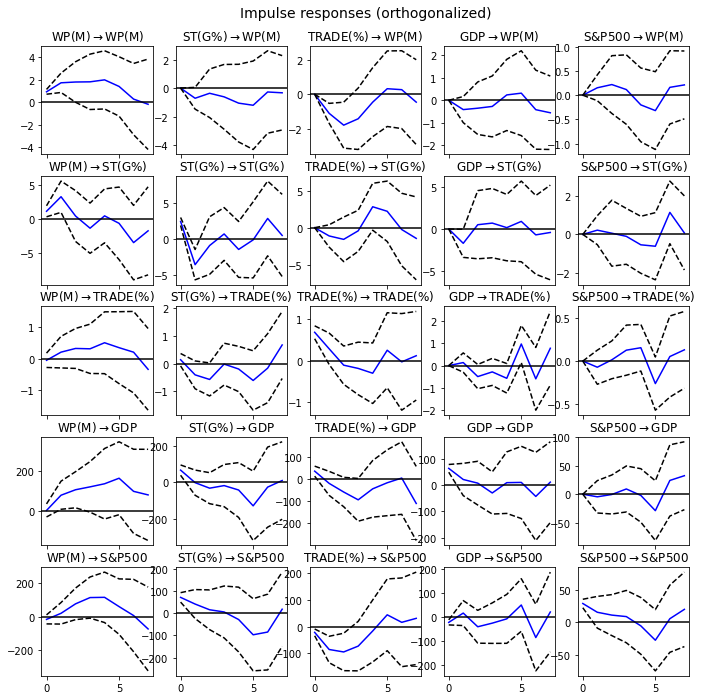

The function plots the Forecast Error Variance Decomposition
FEVD for WP(M)
        WP(M)    ST(G%)  TRADE(%)       GDP    S&P500
0    1.000000  0.000000  0.000000  0.000000  0.000000
1    0.672057  0.087287  0.206844  0.029765  0.004048
2    0.572369  0.050952  0.347174  0.023778  0.005728
3    0.573660  0.055474  0.345805  0.020400  0.004661
4    0.611377  0.089720  0.275488  0.018129  0.005286

FEVD for ST(G%)
        WP(M)    ST(G%)  TRADE(%)       GDP    S&P500
0    0.170788  0.829212  0.000000  0.000000  0.000000
1    0.343741  0.534724  0.037015  0.083102  0.001418
2    0.313751  0.503364  0.099833  0.081668  0.001383
3    0.338171  0.476388  0.096615  0.087307  0.001519
4    0.271760  0.418132  0.233488  0.069819  0.006800

FEVD for TRADE(%)
        WP(M)    ST(G%)  TRADE(%)       GDP    S&P500
0    0.005021  0.039319  0.955661  0.000000  0.000000
1    0.056407  0.227684  0.686401  0.023153  0.006355
2    0.101027  0.342068  0.379945  0.173369  0.003591
3    0.144609  0.296810 

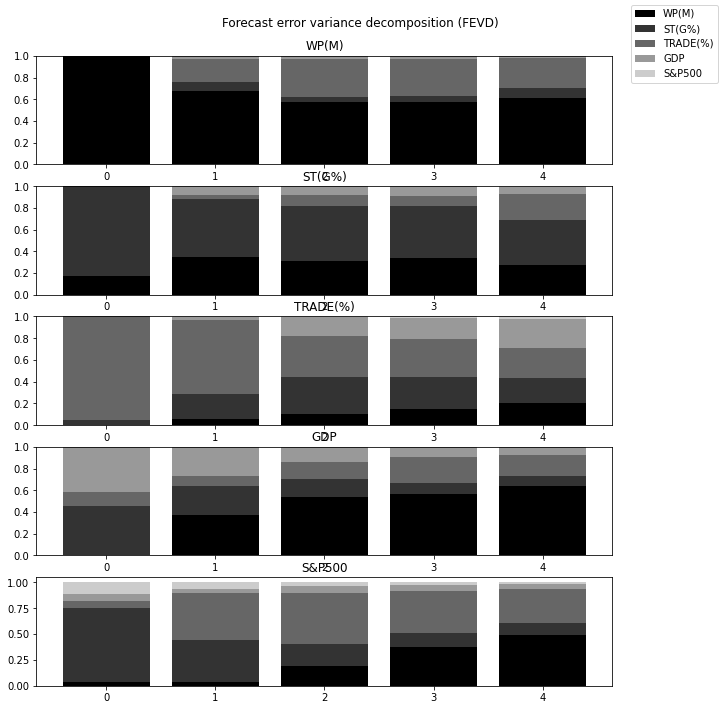

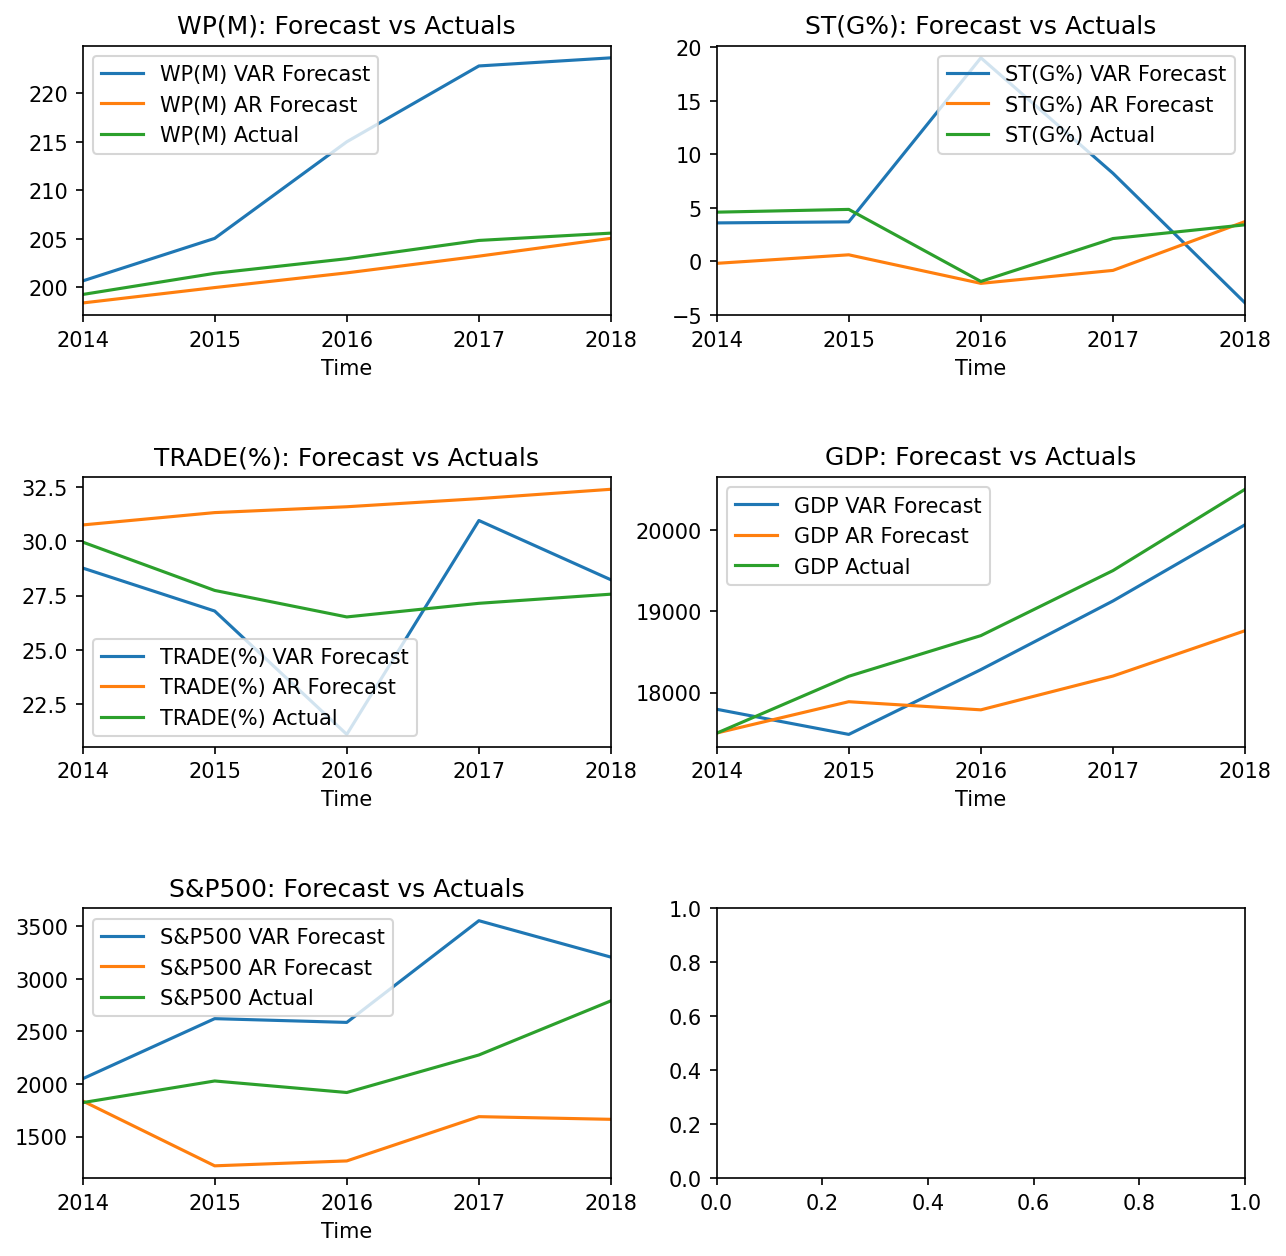

In [15]:
# Figure 12
variables5 = ["WP(M)","ST(G%)","TRADE(%)","GDP","S&P500"]
cointegration_test(usa[variables5].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables5].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
WP(M)  ::  143.15    > 60.0627   =>   True
ST(G%) ::  73.11     > 40.1749   =>   True
TRADE(%) ::  39.39     > 24.2761   =>   True
RGDP   ::  20.57     > 12.3212   =>   True
S&P500 ::  4.78      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:13:01
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    21.8302
Nobs:                     37.0000    HQIC:                   17.4609
Log likelihood:          -386.515    FPE:                1.52408e+08
AIC:                      15.0817    Det(Omega_mle):     7.26897e+06
--------------------------------------------------------------------
Results for equation WP(M)
                 coefficient       std. error        

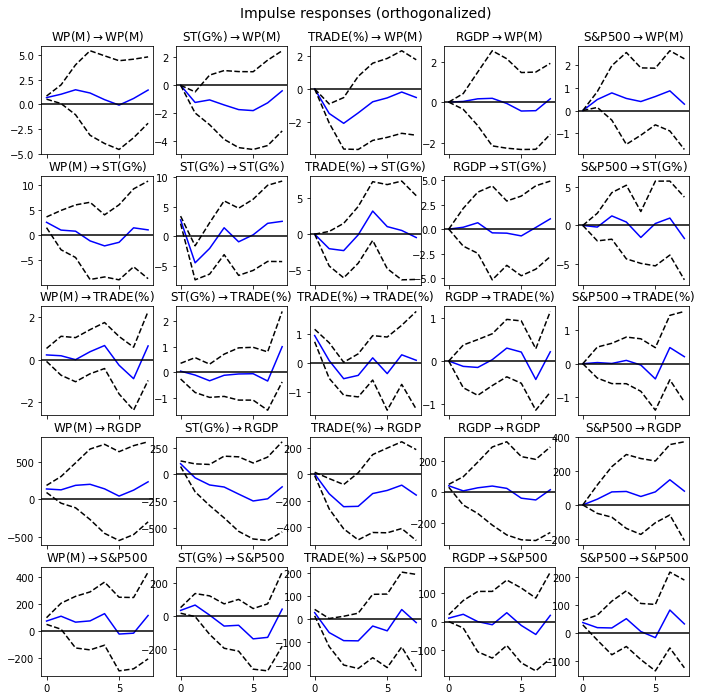

The function plots the Forecast Error Variance Decomposition
FEVD for WP(M)
        WP(M)    ST(G%)  TRADE(%)      RGDP    S&P500
0    1.000000  0.000000  0.000000  0.000000  0.000000
1    0.284984  0.272589  0.398965  0.000189  0.043273
2    0.276074  0.187996  0.472377  0.001981  0.061572
3    0.264329  0.233484  0.440828  0.003193  0.058165
4    0.229296  0.321581  0.391276  0.002842  0.055006

FEVD for ST(G%)
        WP(M)    ST(G%)  TRADE(%)      RGDP    S&P500
0    0.445308  0.554692  0.000000  0.000000  0.000000
1    0.183565  0.710020  0.104319  0.000942  0.001154
2    0.151483  0.626394  0.182414  0.008986  0.030723
3    0.166932  0.620572  0.169521  0.010929  0.032047
4    0.190503  0.474989  0.267117  0.010446  0.056946

FEVD for TRADE(%)
        WP(M)    ST(G%)  TRADE(%)      RGDP    S&P500
0    0.050802  0.002454  0.946744  0.000000  0.000000
1    0.079265  0.012960  0.891337  0.015300  0.001138
2    0.056215  0.083458  0.832949  0.026531  0.000846
3    0.123848  0.074529 

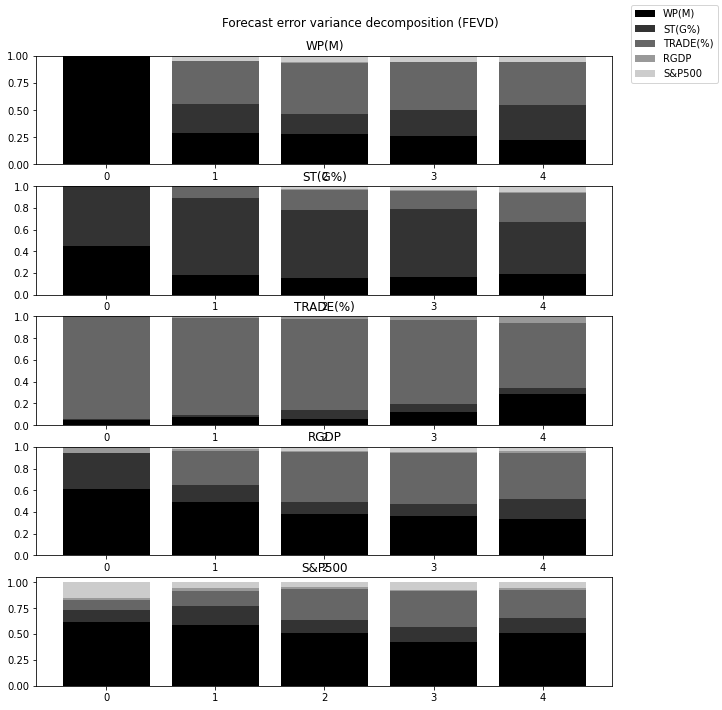

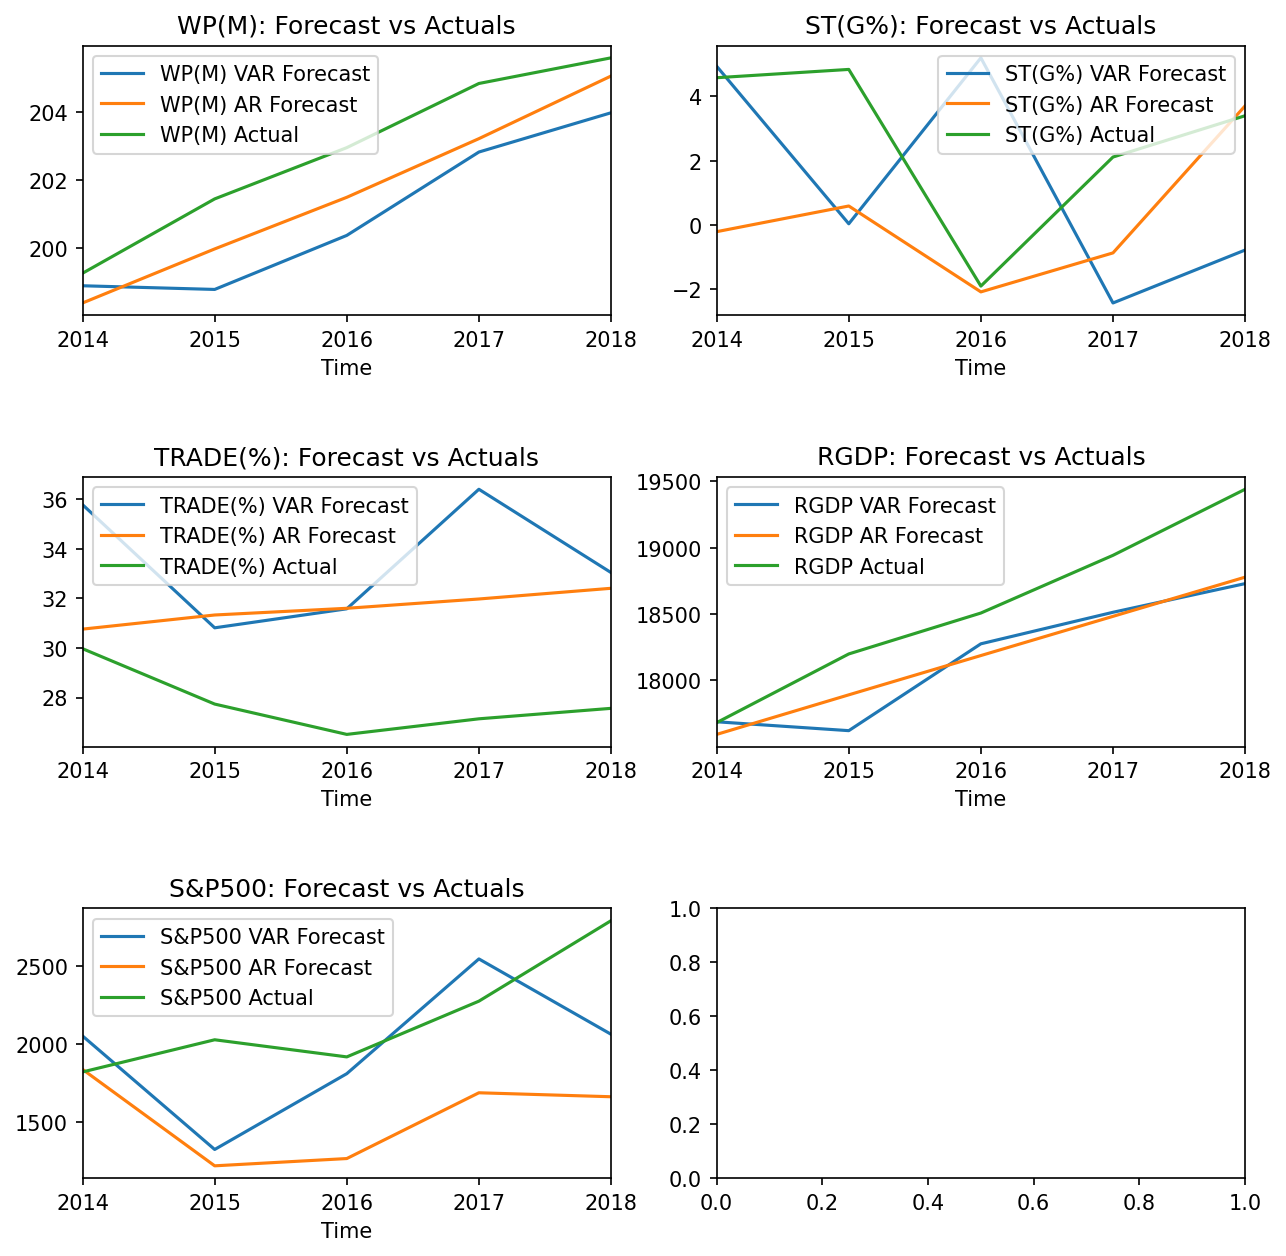

In [16]:
# Figure 13
variables6 = ["WP(M)","ST(G%)","TRADE(%)","RGDP","S&P500"]
cointegration_test(usa[variables6].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables6].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
INF    ::  173.75    > 60.0627   =>   True
WP(G%) ::  89.67     > 40.1749   =>   True
R&D(G%) ::  43.08     > 24.2761   =>   True
GFCF(G%) ::  19.01     > 12.3212   =>   True
GDP(G%) ::  4.73      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:13:09
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    7.61313
Nobs:                     34.0000    HQIC:                   4.50690
Log likelihood:          -185.509    FPE:                    51.1530
AIC:                      2.89937    Det(Omega_mle):         4.61798
--------------------------------------------------------------------
Results for equation INF
                 coefficient       std. error        

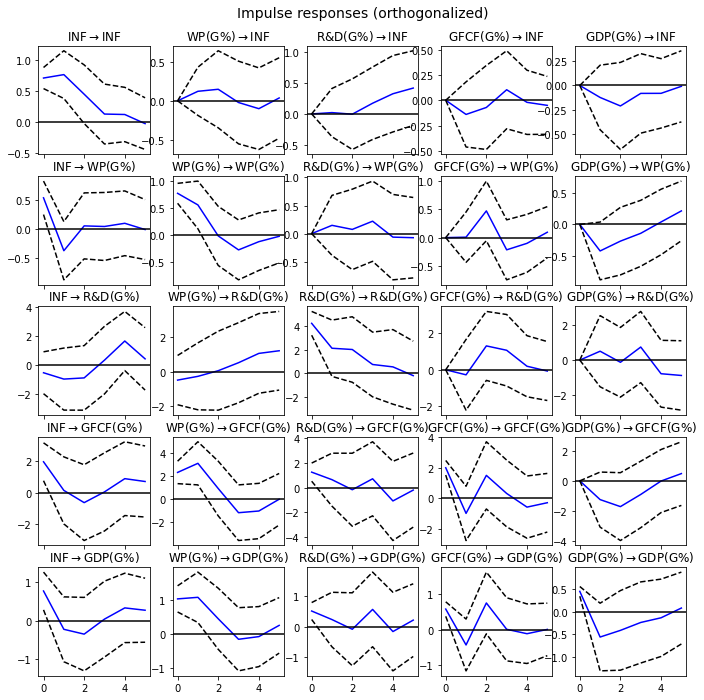

The function plots the Forecast Error Variance Decomposition
FEVD for INF
          INF    WP(G%)   R&D(G%)  GFCF(G%)   GDP(G%)
0    1.000000  0.000000  0.000000  0.000000  0.000000
1    0.956471  0.012729  0.000400  0.016975  0.013425
2    0.914754  0.025332  0.000334  0.017194  0.042385
3    0.886439  0.024515  0.020339  0.023691  0.045016
4    0.820589  0.028473  0.083789  0.021916  0.045232

FEVD for WP(G%)
          INF    WP(G%)   R&D(G%)  GFCF(G%)   GDP(G%)
0    0.325048  0.674952  0.000000  0.000000  0.000000
1    0.280986  0.593510  0.013930  0.000039  0.111535
2    0.237113  0.497898  0.014722  0.119667  0.130599
3    0.215882  0.487797  0.037175  0.131193  0.127953
4    0.216322  0.485485  0.038322  0.133602  0.126268

FEVD for R&D(G%)
          INF    WP(G%)   R&D(G%)  GFCF(G%)   GDP(G%)
0    0.017309  0.012581  0.970110  0.000000  0.000000
1    0.054127  0.012385  0.920135  0.003056  0.010297
2    0.069811  0.009870  0.855229  0.056491  0.008599
3    0.067088  0.017345  0.

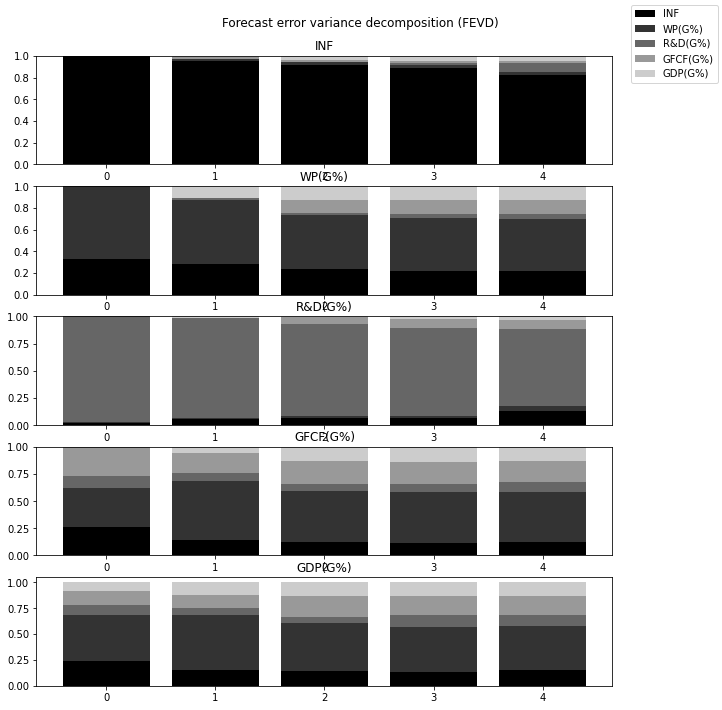

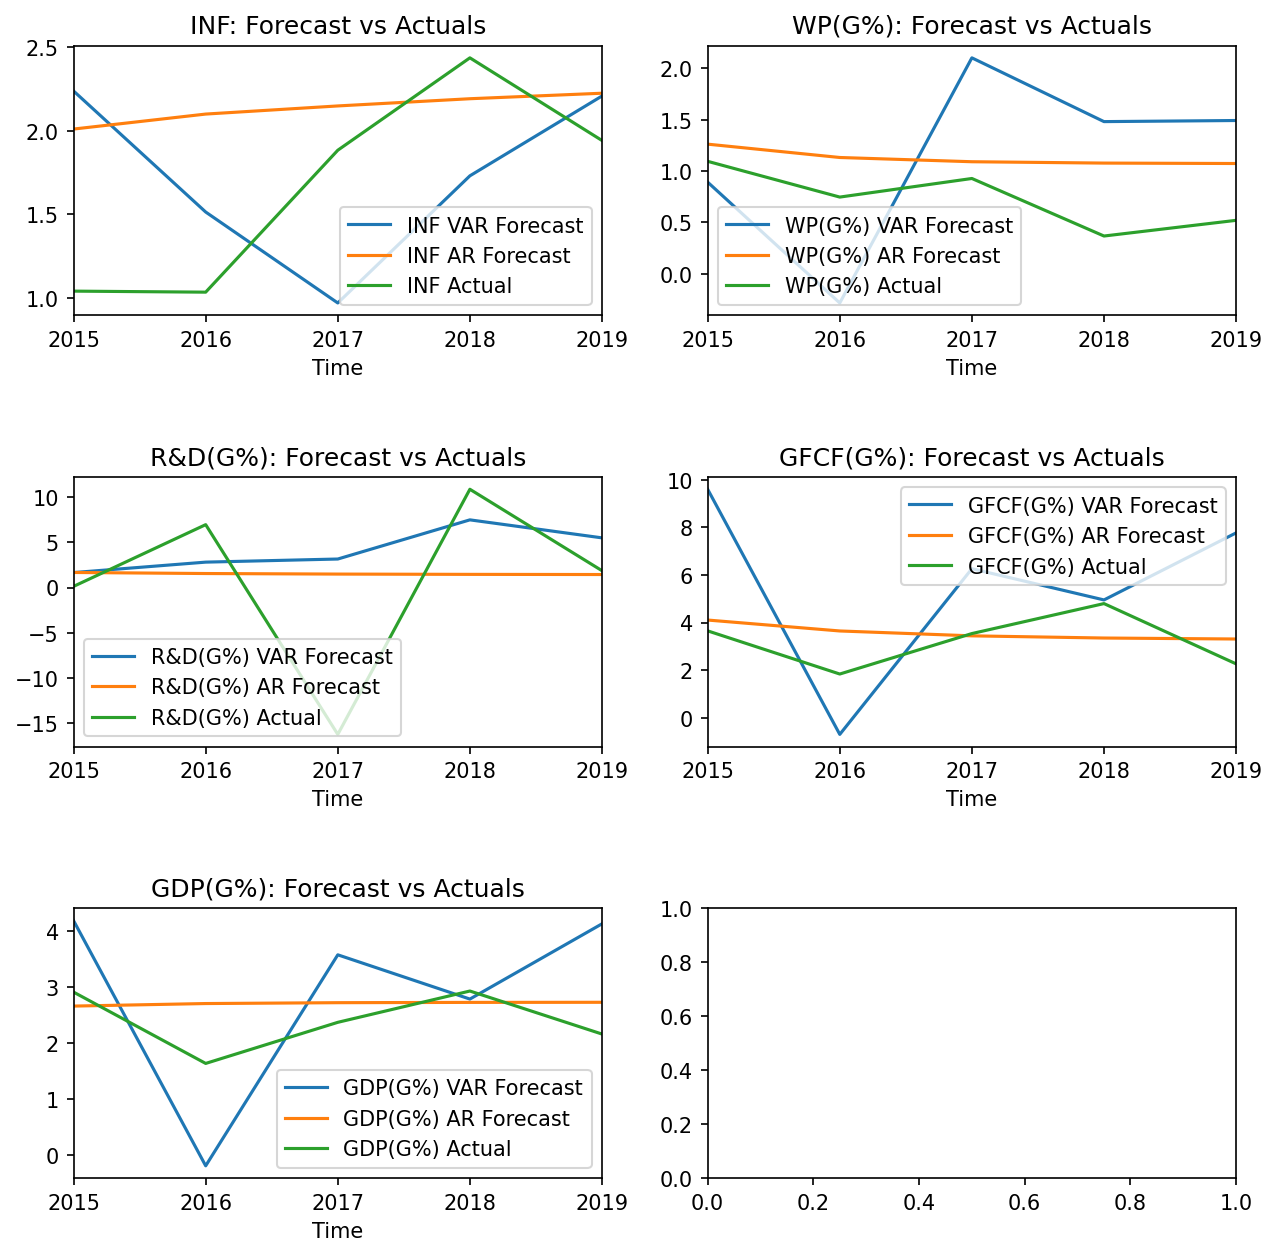

In [17]:
# Figure 14 and 16
variables7 = ["INF","WP(G%)","R&D(G%)","GFCF(G%)","GDP(G%)"]
cointegration_test(usa[variables7].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables7].dropna(),order = 5)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
INF    ::  240.97    > 60.0627   =>   True
WP(G%) ::  103.26    > 40.1749   =>   True
R&D(G%) ::  42.93     > 24.2761   =>   True
S&P500(G%) ::  24.62     > 12.3212   =>   True
GDP(G%) ::  8.98      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:13:17
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    11.9191
Nobs:                     34.0000    HQIC:                   8.81288
Log likelihood:          -258.711    FPE:                    3792.58
AIC:                      7.20535    Det(Omega_mle):         342.386
--------------------------------------------------------------------
Results for equation INF
                   coefficient       std. error    

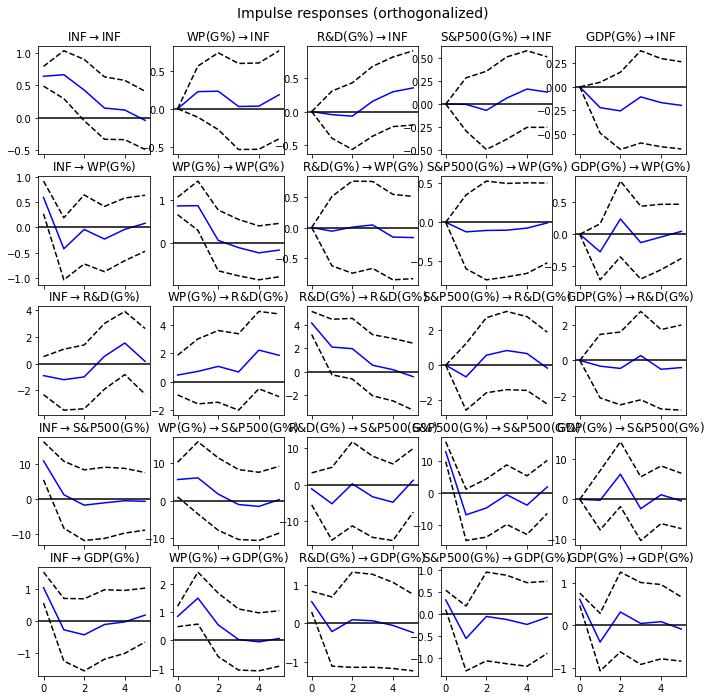

The function plots the Forecast Error Variance Decomposition
FEVD for INF
          INF    WP(G%)   R&D(G%)  S&P500(G%)   GDP(G%)
0    1.000000  0.000000  0.000000    0.000000  0.000000
1    0.892846  0.053437  0.002291    0.000017  0.051409
2    0.817673  0.082669  0.005479    0.003844  0.090334
3    0.796118  0.079485  0.022974    0.006835  0.094588
4    0.721029  0.071848  0.079385    0.024276  0.103461

FEVD for WP(G%)
          INF    WP(G%)   R&D(G%)  S&P500(G%)   GDP(G%)
0    0.316702  0.683298  0.000000    0.000000  0.000000
1    0.246833  0.708679  0.001705    0.006999  0.035785
2    0.239398  0.686603  0.001667    0.011710  0.060623
3    0.252578  0.663747  0.002392    0.015650  0.065633
4    0.243739  0.662134  0.012811    0.017371  0.063945

FEVD for R&D(G%)
          INF    WP(G%)   R&D(G%)  S&P500(G%)   GDP(G%)
0    0.044106  0.011570  0.944323    0.000000  0.000000
1    0.089275  0.028930  0.860102    0.017562  0.004131
2    0.102064  0.059244  0.804930    0.024091  0.00

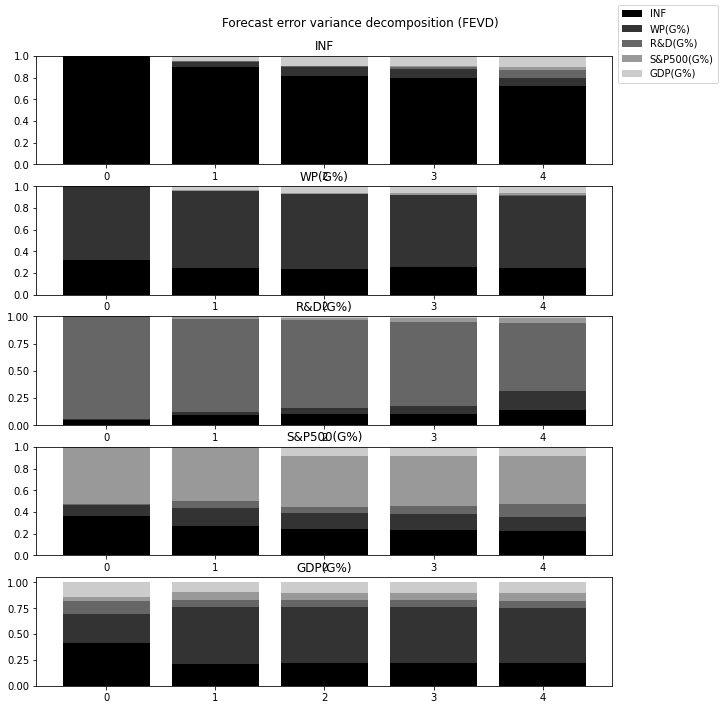

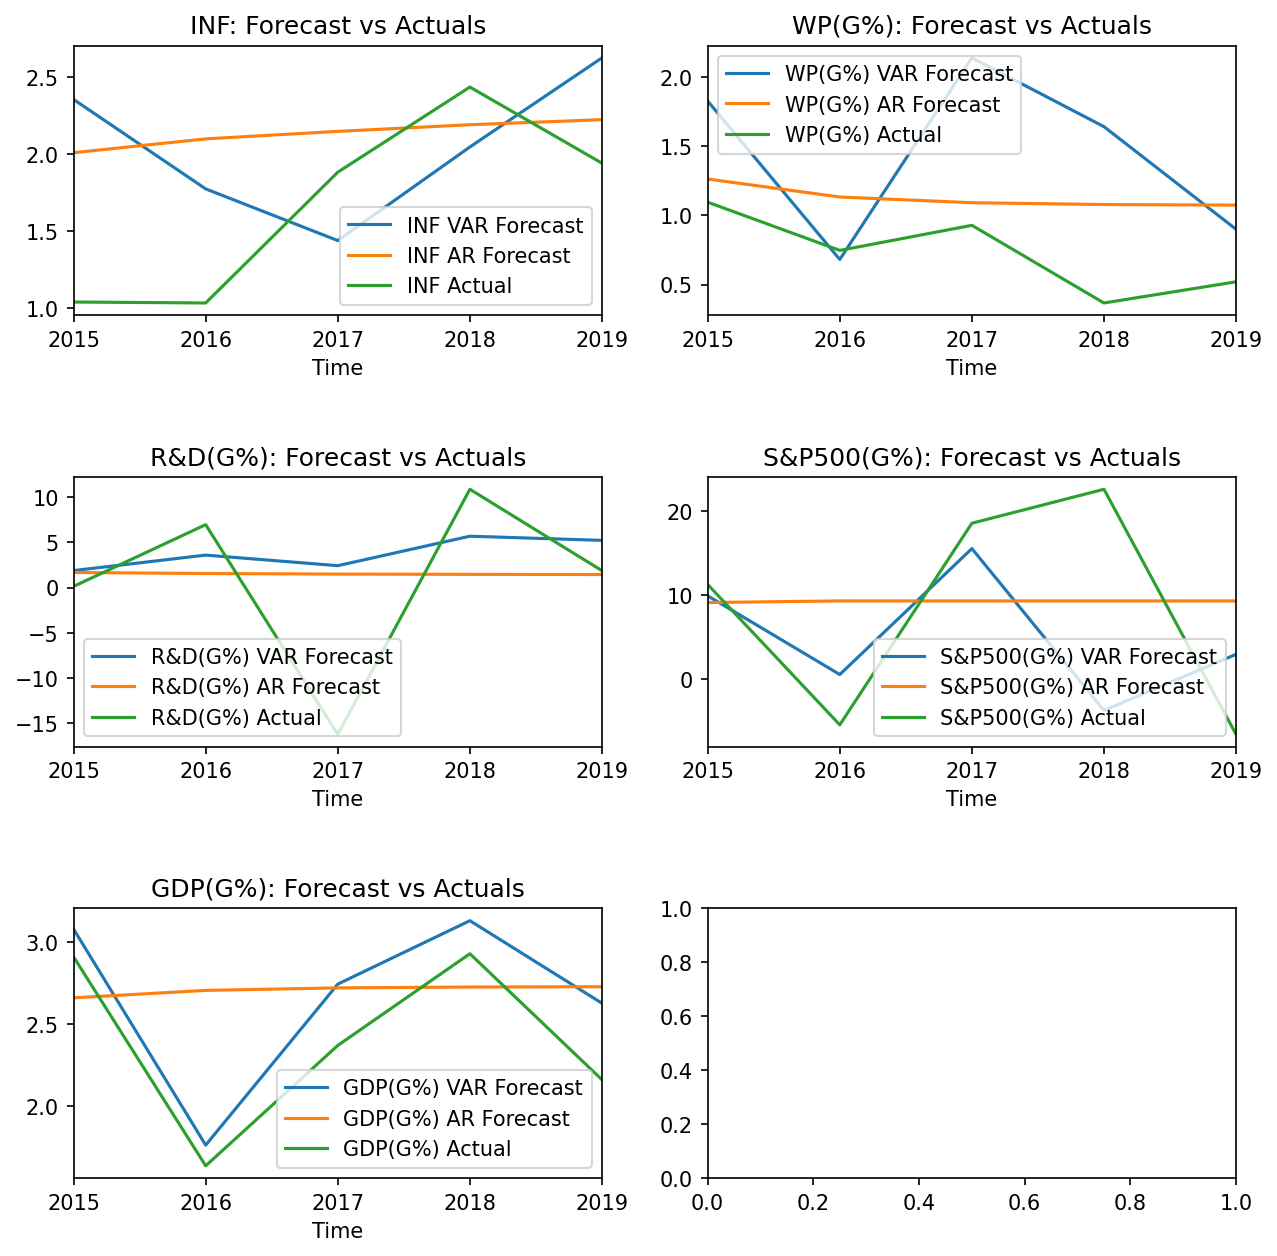

In [18]:
# Figure 15 and 17
variables8 = ["INF","WP(G%)","R&D(G%)","S&P500(G%)","GDP(G%)"]
cointegration_test(usa[variables8].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables8].dropna(),order = 5)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
R&D(G%) ::  40.6      > 24.2761   =>   True
S&P500(G%) ::  16.42     > 12.3212   =>   True
GDPIF(G%) ::  5.13      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:13:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.2308
Nobs:                     37.0000    HQIC:                   9.89251
Log likelihood:          -325.106    FPE:                    16495.8
AIC:                      9.70832    Det(Omega_mle):         12123.5
--------------------------------------------------------------------
Results for equation R&D(G%)
                   coefficient       std. error           t-stat            prob
--------------------------------------------------

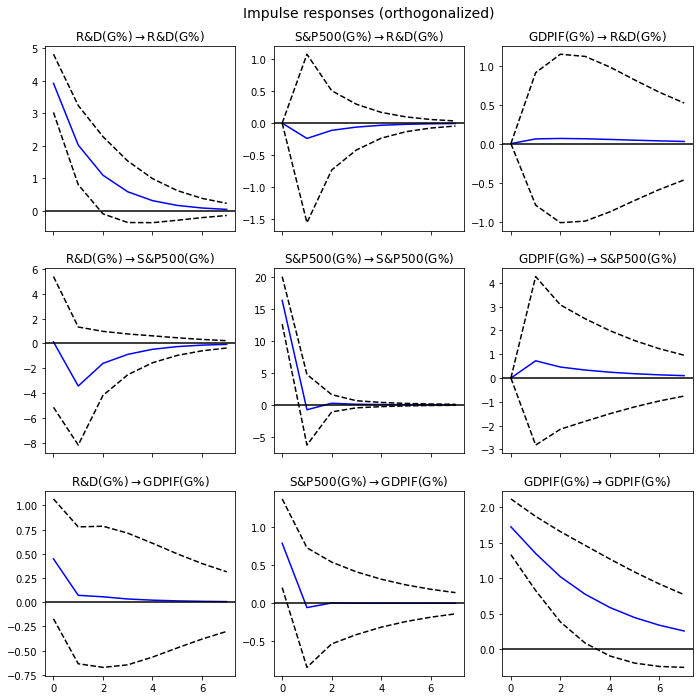

The function plots the Forecast Error Variance Decomposition
FEVD for R&D(G%)
      R&D(G%)  S&P500(G%)  GDPIF(G%)
0    1.000000    0.000000   0.000000
1    0.996864    0.002950   0.000187
2    0.996226    0.003386   0.000388
3    0.995927    0.003509   0.000564
4    0.995761    0.003543   0.000696

FEVD for S&P500(G%)
      R&D(G%)  S&P500(G%)  GDPIF(G%)
0    0.000056    0.999944   0.000000
1    0.042070    0.956048   0.001882
2    0.050745    0.946634   0.002622
3    0.053310    0.943675   0.003014
4    0.054040    0.942736   0.003224

FEVD for GDPIF(G%)
      R&D(G%)  S&P500(G%)  GDPIF(G%)
0    0.052749    0.164925   0.782326
1    0.036521    0.111943   0.851536
2    0.031268    0.094421   0.874311
3    0.028835    0.086622   0.884543
4    0.027585    0.082695   0.889720


Durbin Watson test is executed
R&D(G%) : 1.85
S&P500(G%) : 1.97
GDPIF(G%) : 2.31
Durbin Watson test is ended
-------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -3.717571
p-value

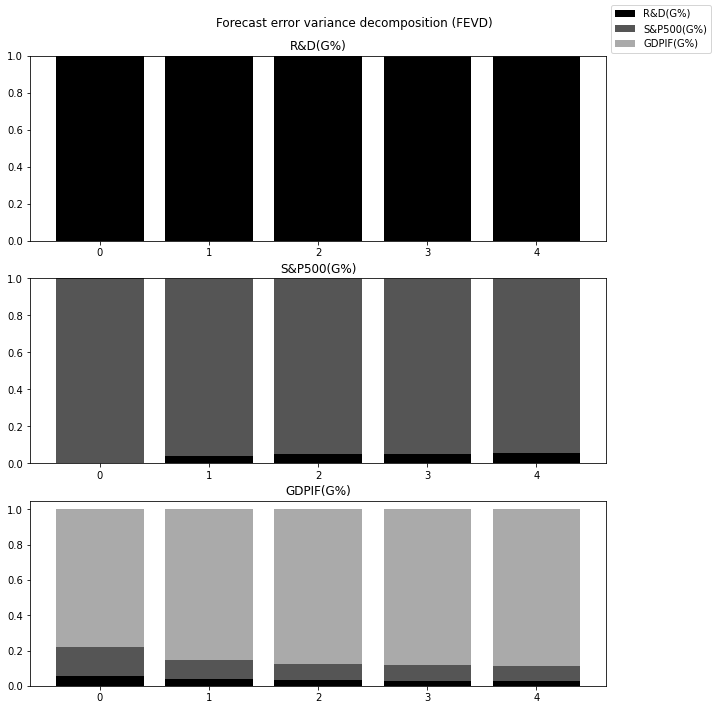

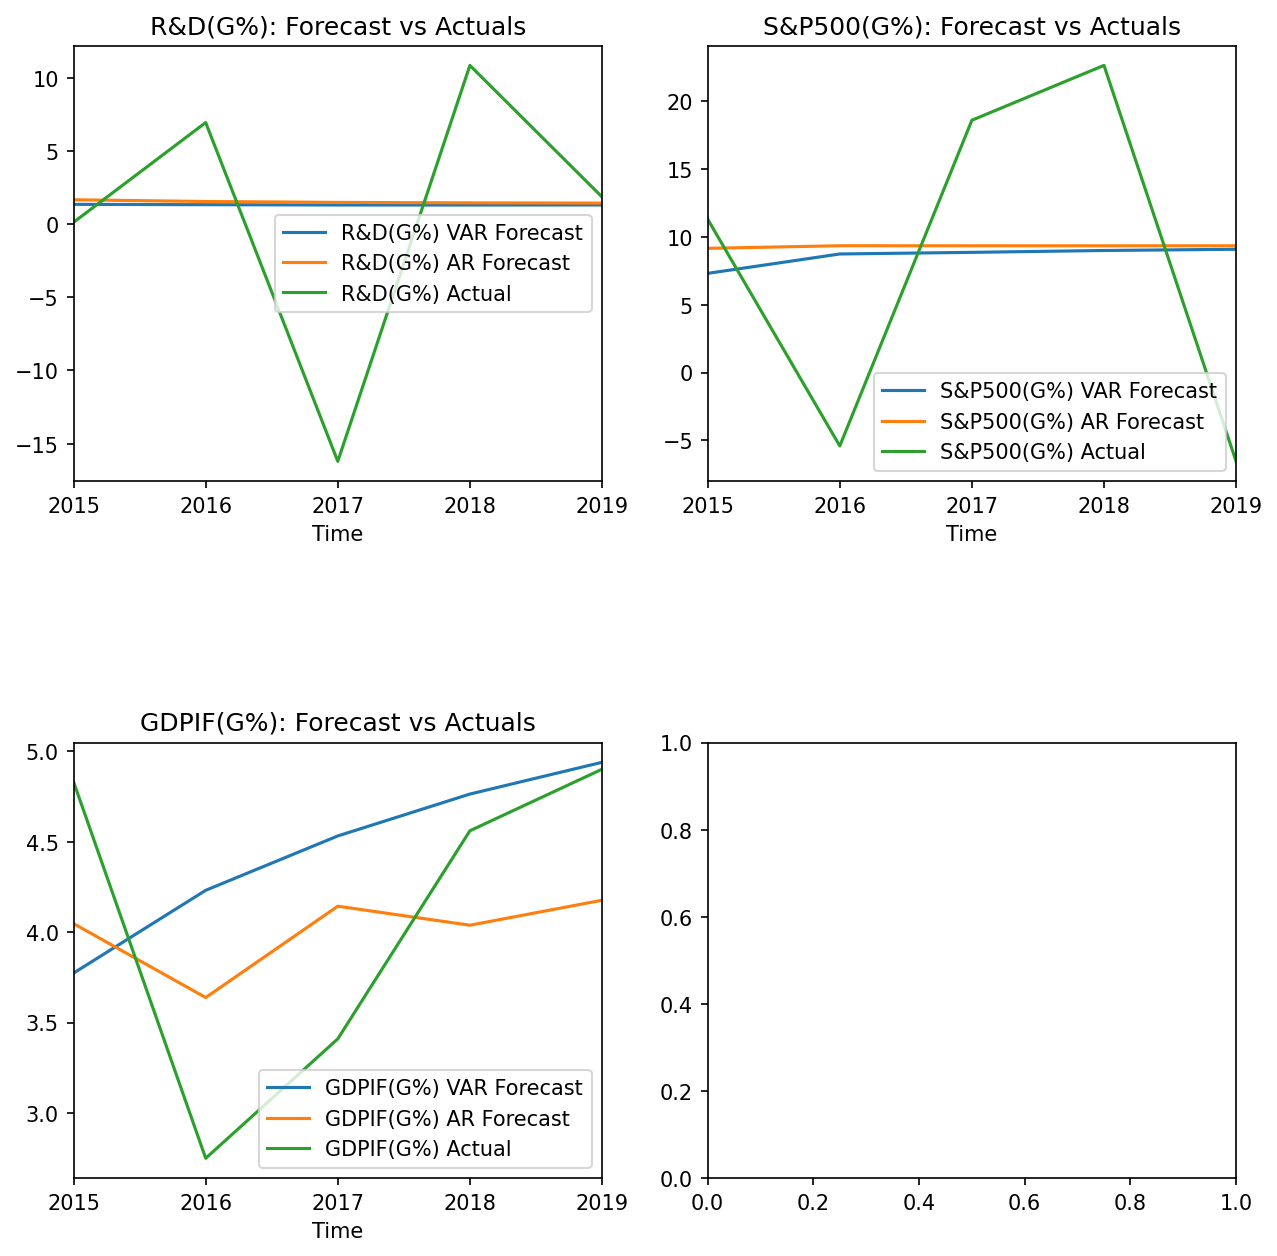

In [19]:
# Figure 18
variables9 = ["R&D(G%)","S&P500(G%)","GDPIF(G%)"]
cointegration_test(usa[variables9].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables9].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
R&D(G%) ::  40.6      > 24.2761   =>   True
S&P500(G%) ::  16.42     > 12.3212   =>   True
GDPIF(G%) ::  5.13      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Dec, 2020
Time:                     19:13:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.2308
Nobs:                     37.0000    HQIC:                   9.89251
Log likelihood:          -325.106    FPE:                    16495.8
AIC:                      9.70832    Det(Omega_mle):         12123.5
--------------------------------------------------------------------
Results for equation R&D(G%)
                   coefficient       std. error           t-stat            prob
--------------------------------------------------

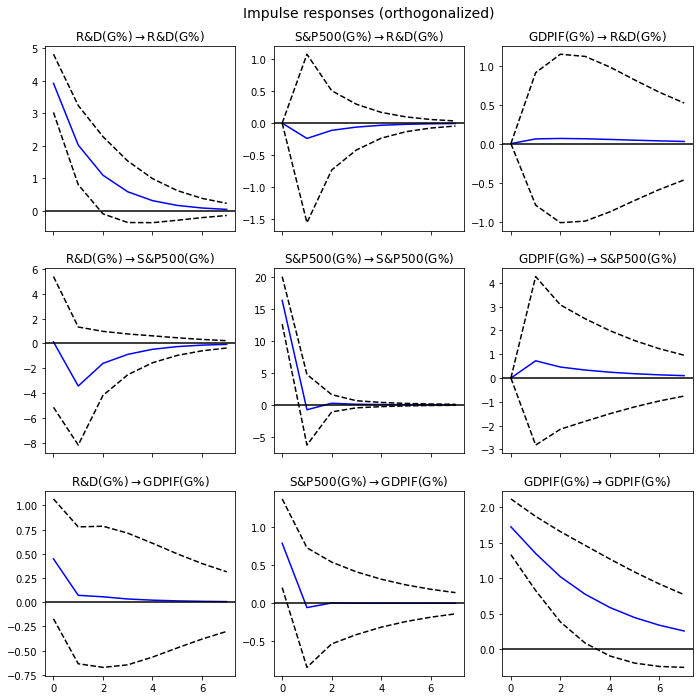

The function plots the Forecast Error Variance Decomposition
FEVD for R&D(G%)
      R&D(G%)  S&P500(G%)  GDPIF(G%)
0    1.000000    0.000000   0.000000
1    0.996864    0.002950   0.000187
2    0.996226    0.003386   0.000388
3    0.995927    0.003509   0.000564
4    0.995761    0.003543   0.000696

FEVD for S&P500(G%)
      R&D(G%)  S&P500(G%)  GDPIF(G%)
0    0.000056    0.999944   0.000000
1    0.042070    0.956048   0.001882
2    0.050745    0.946634   0.002622
3    0.053310    0.943675   0.003014
4    0.054040    0.942736   0.003224

FEVD for GDPIF(G%)
      R&D(G%)  S&P500(G%)  GDPIF(G%)
0    0.052749    0.164925   0.782326
1    0.036521    0.111943   0.851536
2    0.031268    0.094421   0.874311
3    0.028835    0.086622   0.884543
4    0.027585    0.082695   0.889720


Durbin Watson test is executed
R&D(G%) : 1.85
S&P500(G%) : 1.97
GDPIF(G%) : 2.31
Durbin Watson test is ended
-------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -3.717571
p-value

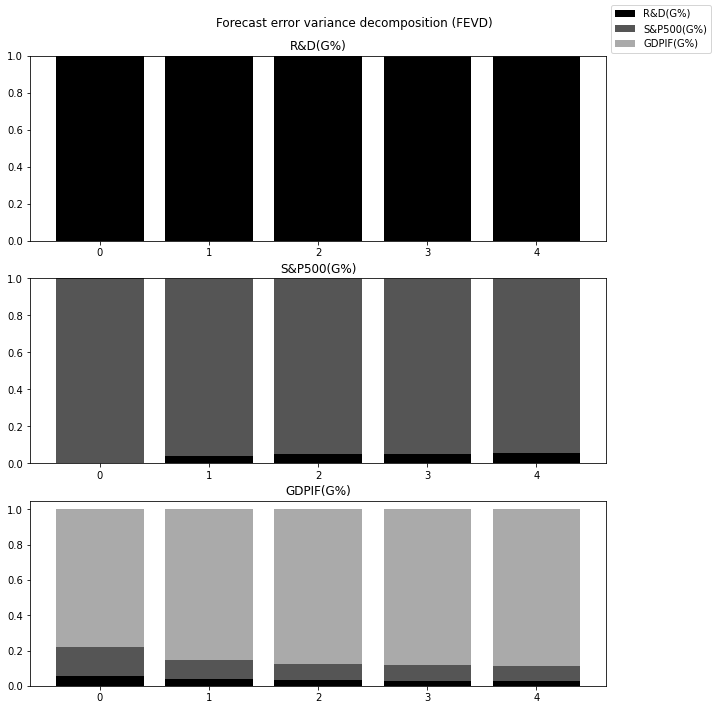

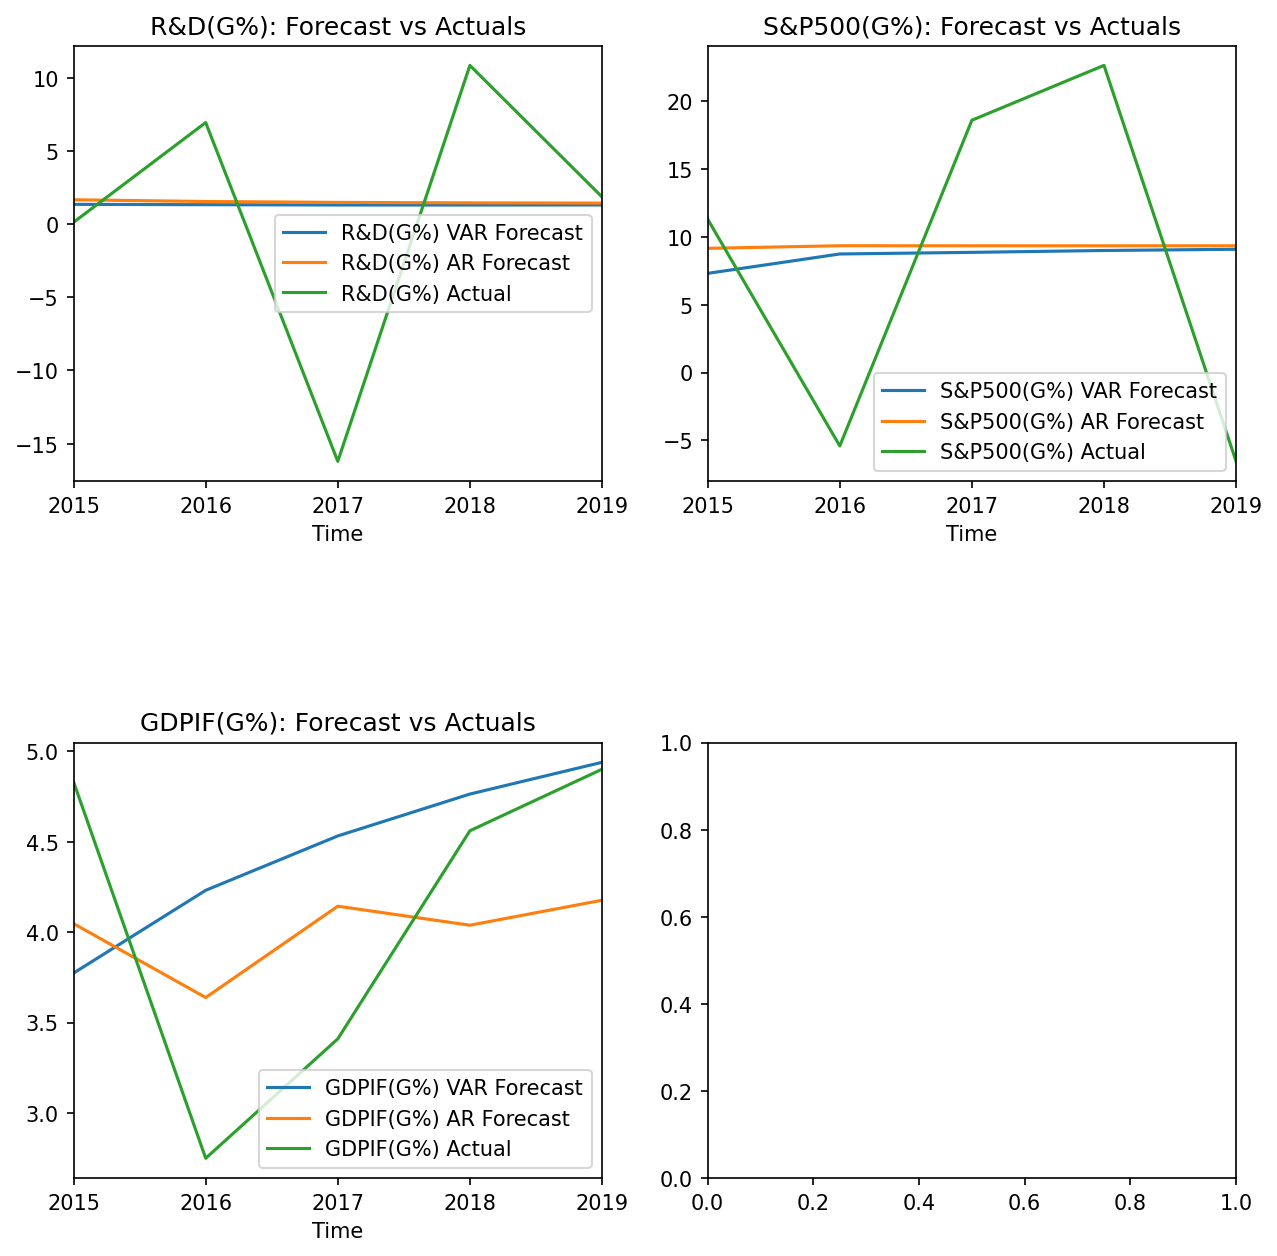

In [20]:
# an additional information for Figure 18
variables9 = ["R&D(G%)","S&P500(G%)","GDPIF(G%)"]
cointegration_test(usa[variables9].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[variables9].dropna())

In [21]:
# import datasets gained from FRED-MD
original_data = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/current.csv",
                   index_col = "sasdate",
                   header = 0,
                   parse_dates = True,
                   dtype='float')

data = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/current_nocode.csv",
                   index_col = "sasdate",
                   header = 0,
                   parse_dates = True,
                   dtype='float')
data.index.freq = "MS"
code = original_data[:1]

#pull the transformation code and save it in a dictionary to adjust data for later analysis.
transformation_code = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values)}

# making a new data and delete the transformation code
USA = data.copy()
USA = USA.loc["11/1/2011":"12/1/2019"].dropna()
USA.index.freq = "MS"
data.head()

# change the data as expected in the FRED-MD
df = adjust_data(USA,transformation_code)

USA.head()

RPI  W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx   INDPRO  \
sasdate                                                                         
2011-11-01  13591.318  11209.0           98.833  1250048.0  391589.0  98.2433   
2011-12-01  13714.357  11322.6           98.893  1261003.0  391837.0  98.7876   
2012-01-01  13776.131  11426.0           99.363  1268460.0  395376.0  99.3925   
2012-02-01  13861.174  11514.2           99.960  1273029.0  400228.0  99.6203   
2012-03-01  13911.509  11555.5           99.763  1271849.0  401804.0  99.1551   

            IPFPNSS  IPFINAL   IPCONGD  IPDCONGD  IPNCONGD  IPBUSEQ    IPMAT  \
sasdate                                                                        
2011-11-01  98.7842  99.1006  100.9840   98.5863  101.5896  94.0878  97.6620   
2011-12-01  99.2532  99.4251  100.9198   99.2185  101.3503  95.6371  98.2869   
2012-01-01  99.6775  99.8527  100.8708  101.7504  100.6551  97.2116  99.0851   
2012-02-01  99.9366  99.9601  100.7393  101.0506  100.6646  97.7900  99.2801   
2012-03-01  99.2333  99.1711   99.1562  100.0007   98.9462  98.6307  99.0702   

              IPDMAT    IPNMAT  IPMANSICS  IPB51222S   IPFUELS   CUMFNS  \
sasdate                                                                   
2011-11-01   97.2617   99.4937    98.3908   100.0920  102.7071  74.0205   
2011-12-01   98.4682   99.8899    99.0906    98.4497  101.4532  74.4631   
2012-01-01   99.3576  100.8647    99.9112    94.0656   99.6775  74.9897   
2012-02-01  100.2795  100.3337   100.2312    93.9359  100.7889  75.1365   
2012-03-01   99.4165   99.8276    99.7542    89.1458   98.9519  74.6844   

               HWI  HWIURATIO   CLF16OV    CE16OV  UNRATE  UEMPMEAN  UEMPLT5  \
sasdate                                                                        
2011-11-01  3485.0   0.261991  154128.0  140826.0     8.6      40.2   2556.0   
2011-12-01  3662.0   0.279691  153995.0  140902.0     8.5      40.4   2678.0   
2012-01-01  3904.0   0.305072  154381.0  141584.0     8.3      40.2   2474.0   
2012-02-01  3605.0   0.281355  154671.0  141858.0     8.3      39.7   2610.0   
2012-03-01  3976.0   0.312751  154749.0  142036.0     8.2      39.3   2708.0   

            UEMP5TO14  UEMP15OV  UEMP15T26  UEMP27OV   CLAIMSx    PAYEMS  \
sasdate                                                                    
2011-11-01     2913.0    7706.0     2009.0    5698.0  389250.0  132694.0   
2011-12-01     2873.0    7545.0     1959.0    5586.0  377000.0  132896.0   
2012-01-01     2908.0    7433.0     1957.0    5476.0  377750.0  133250.0   
2012-02-01     2848.0    7293.0     2051.0    5242.0  363250.0  133512.0   
2012-03-01     2788.0    7176.0     1940.0    5236.0  366600.0  133752.0   

             USGOOD  CES1021000001  USCONS   MANEMP  DMANEMP  NDMANEMP  \
sasdate                                                                  
2011-11-01  18187.0          775.1  5593.0  11770.0   7331.0    4439.0   
2011-12-01  18244.0          781.4  5611.0  11802.0   7368.0    4434.0   
2012-01-01  18304.0          789.1  5626.0  11838.0   7398.0    4440.0   
2012-02-01  18334.0          795.5  5629.0  11860.0   7420.0    4440.0   
2012-03-01  18372.0          799.0  5625.0  11898.0   7446.0    4452.0   

              SRVPRD    USTPU  USWTRADE  USTRADE  USFIRE   USGOVT  \
sasdate                                                             
2011-11-01  114507.0  25151.0    5515.0  14754.8  7721.0  21971.0   
2011-12-01  114652.0  25162.0    5534.7  14747.0  7729.0  21954.0   
2012-01-01  114946.0  25267.0    5550.3  14817.1  7735.0  21946.0   
2012-02-01  115178.0  25283.0    5562.4  14795.3  7743.0  21947.0   
2012-03-01  115380.0  25326.0    5568.8  14826.1  7768.0  21943.0   

            CES0600000007  AWOTMAN  AWHMAN  HOUST  HOUSTNE  HOUSTMW  HOUSTS  \
sasdate                                                                       
2011-11-01           41.0      4.1    41.5  711.0     99.0     93.0   348.0   
2011-12-01           41.1    

In [22]:
# Figure 19
new = ['TOTRESNS', 'COMPAPFFx', "CMRMTSPLx", 'CLAIMSx', 'INDPRO', 'TB3SMFFM']
grangers_causation_matrix(df[new].dropna(),variables=new)

TOTRESNS_x COMPAPFFx_x CMRMTSPLx_x CLAIMSx_x INDPRO_x TB3SMFFM_x
TOTRESNS_y           1      0.0128       False     False    False      False
COMPAPFFx_y      False           1       False     False   0.0221      0.007
CMRMTSPLx_y     0.0002       False           1     False    0.044      False
CLAIMSx_y        False       False       False         1   0.0432      False
INDPRO_y         False       False      0.0018    0.0495        1      False
TB3SMFFM_y       False      0.0039      0.0244     False   0.0063          1

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  70.1      > 60.0627   =>   True
CLAIMSx ::  37.51     > 40.1749   =>   False
CMRMTSPLx ::  17.09     > 24.2761   =>   False
INDPRO ::  3.49      > 12.3212   =>   False
TB3SMFFM ::  0.49      > 4.1296    =>   False
                               AR Model Results                               
Dep. Variable:                      C  -                  M                  R
Model:                          AR(3)   Log Likelihood                -843.446
Method:                          cmle   S.D. of innovations           6267.054
Date:                Wed, 23 Dec 2020   AIC                             17.607
Time:                        19:13:34   BIC                             17.752
Sample:                    11-01-2011   HQIC                            17.665
                         - 12-01-2018                                         
                   coef    std err          z      P>

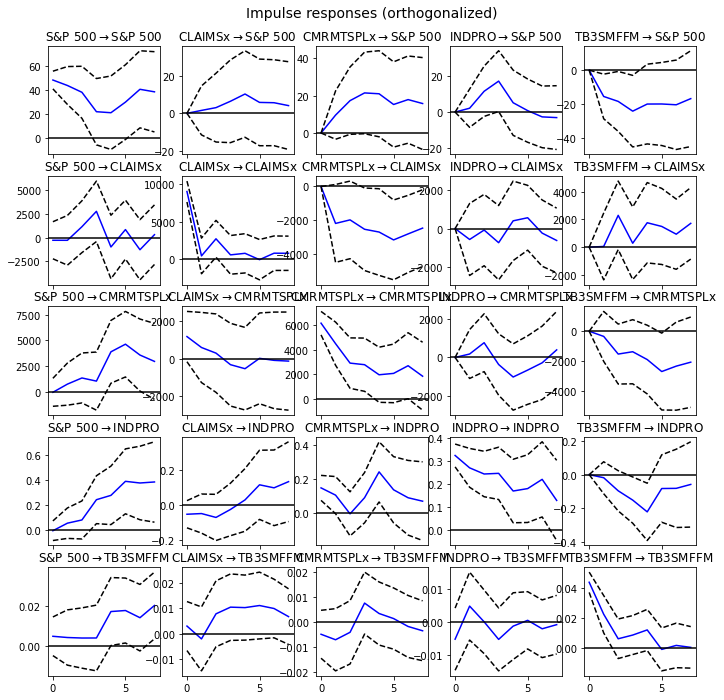

The function plots the Forecast Error Variance Decomposition
FEVD for S&P 500
       S&P 500   CLAIMSx  CMRMTSPLx    INDPRO  TB3SMFFM
0     1.000000  0.000000   0.000000  0.000000  0.000000
1     0.926642  0.000526   0.019797  0.000977  0.052059
2     0.836877  0.001699   0.057047  0.019810  0.084566
3     0.713515  0.006118   0.097679  0.049000  0.133688
4     0.657354  0.015773   0.127568  0.044788  0.154518
5     0.646110  0.016577   0.130472  0.038868  0.167973
6     0.652162  0.015993   0.130614  0.032669  0.168563
7     0.661715  0.015019   0.129461  0.029111  0.164694
8     0.680848  0.014450   0.121437  0.026536  0.156729
9     0.686059  0.014056   0.117158  0.024907  0.157821
10    0.687471  0.014381   0.114943  0.024610  0.158595
11    0.686817  0.014580   0.115030  0.024137  0.159435

FEVD for CLAIMSx
       S&P 500   CLAIMSx  CMRMTSPLx    INDPRO  TB3SMFFM
0     0.000942  0.999058   0.000000  0.000000  0.000000
1     0.001788  0.938470   0.056060  0.003648  0.000033
2     0.

{'CMRMTSPLx': 3, 'INDPRO': 1, 'CLAIMSx': 2, 'S&P 500': 1, 'TB3SMFFM': 3}

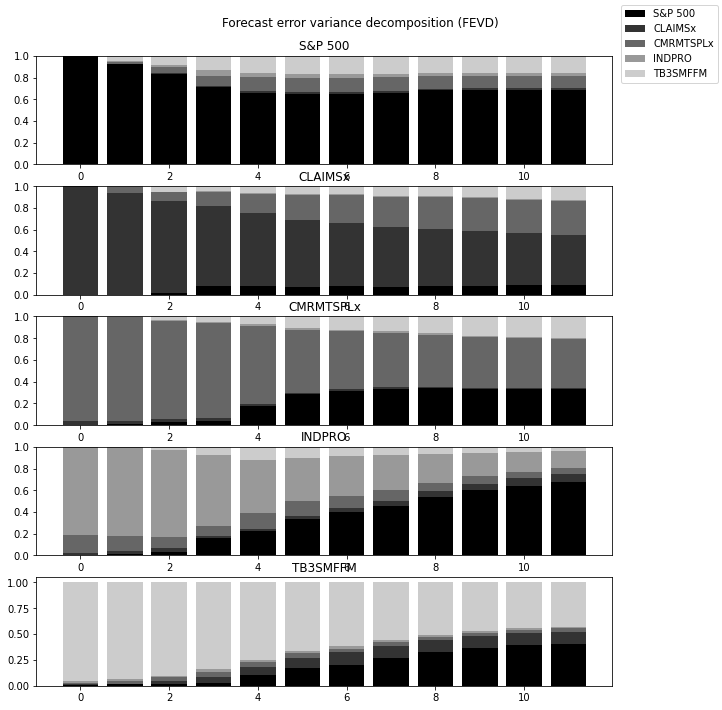

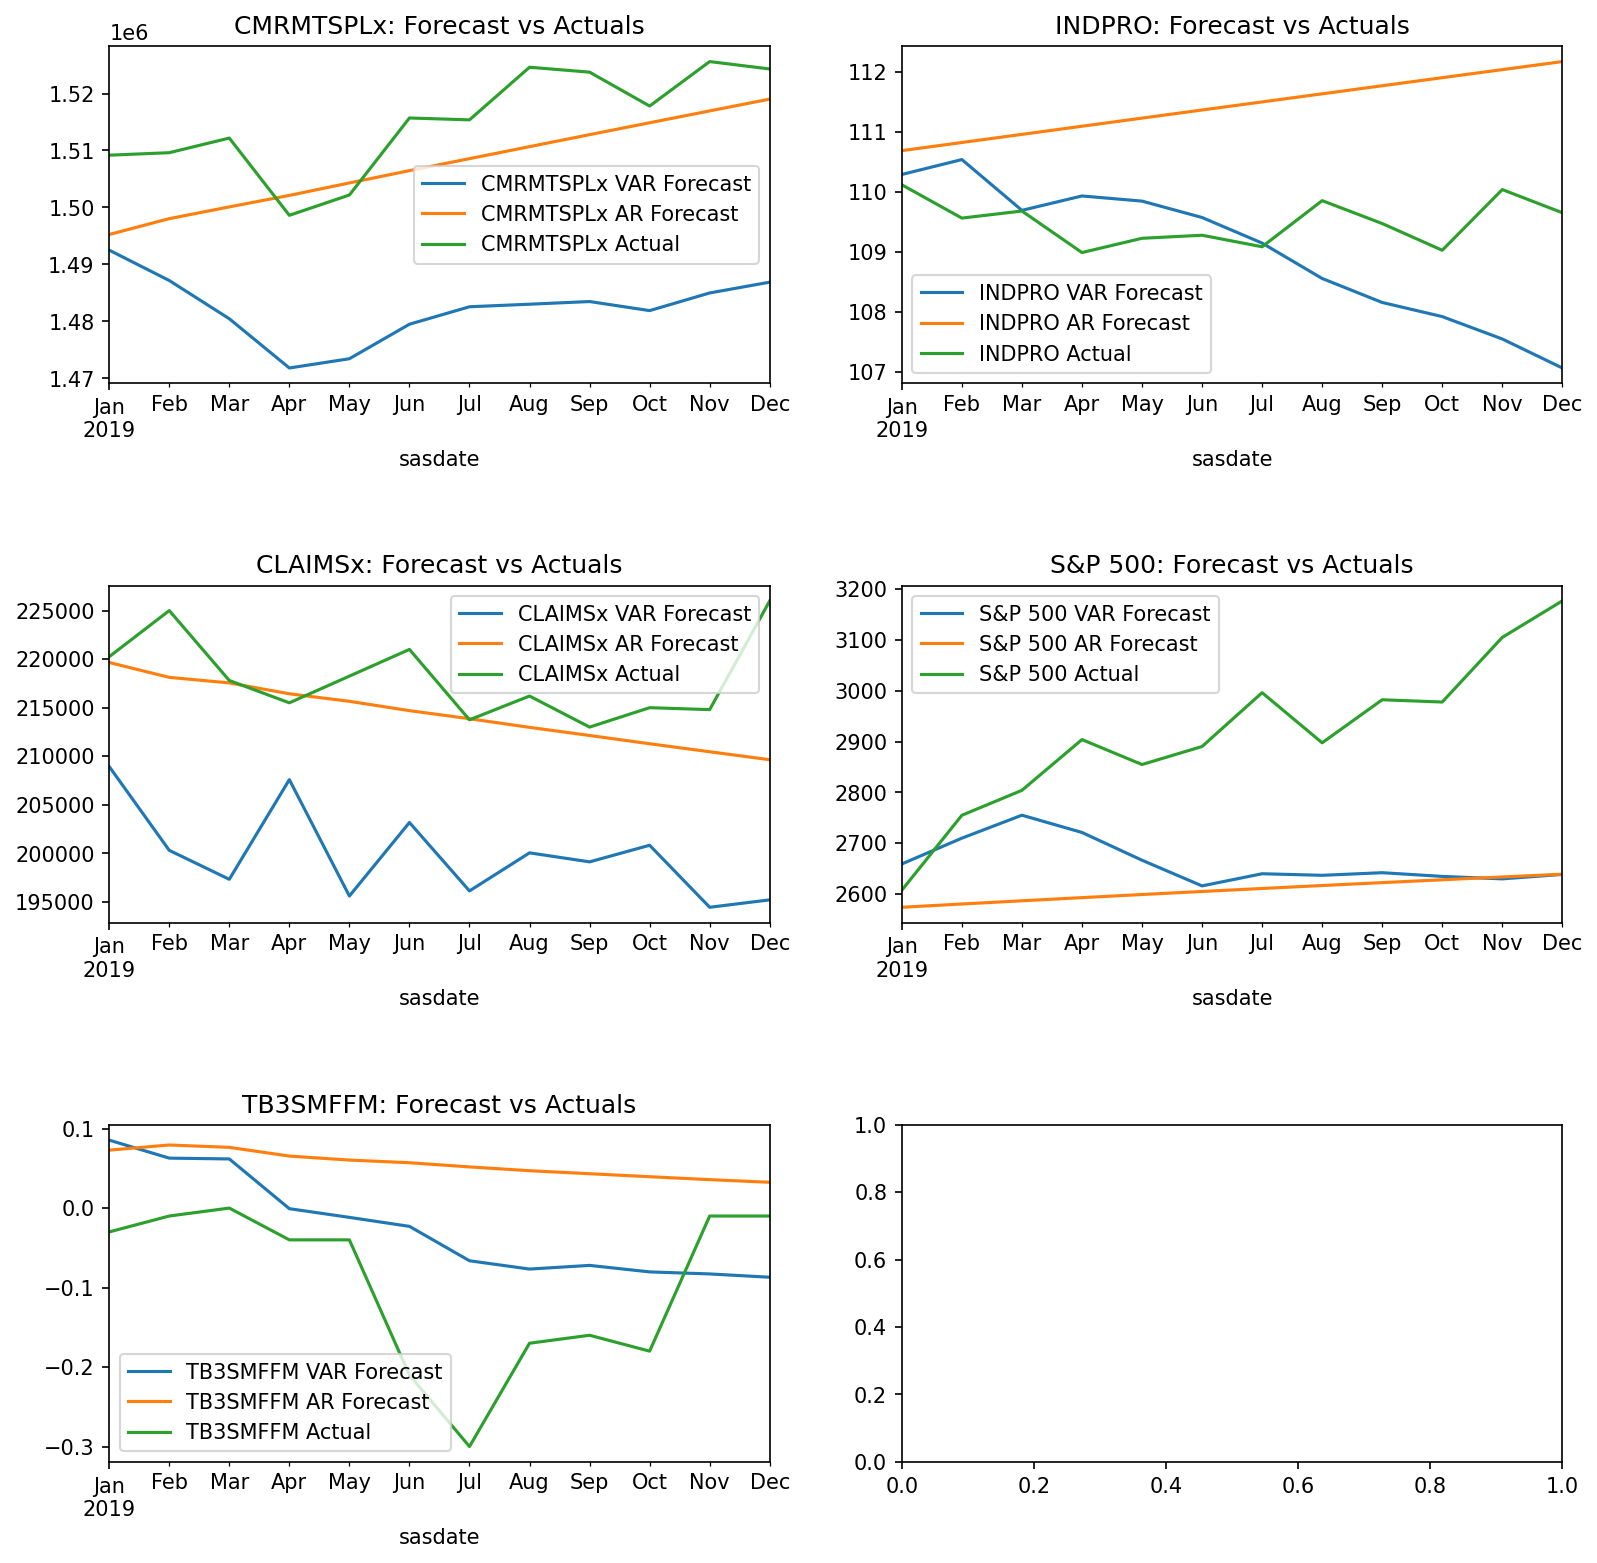

In [23]:
# Figure 20
variables10 = ["S&P 500","CLAIMSx","CMRMTSPLx","INDPRO","TB3SMFFM"]
cointegration_test(USA[variables10],alpha = 0.05)
code = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in variables10}
coin_evaluate_plot(USA[variables10],code,num=12)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
TOTRESNS ::  88.36     > 60.0627   =>   True
COMPAPFFx ::  53.69     > 40.1749   =>   True
CLAIMSx ::  31.55     > 24.2761   =>   True
INDPRO ::  14.16     > 12.3212   =>   True
S&P 500 ::  6.66      > 4.1296    =>   True
                               AR Model Results                               
Dep. Variable:                      I  -                  N                  D
Model:                          AR(1)   Log Likelihood                 -59.789
Method:                          cmle   S.D. of innovations              0.489
Date:                Wed, 23 Dec 2020   AIC                             -1.360
Time:                        19:13:43   BIC                             -1.274
Sample:                    11-01-2011   HQIC                            -1.326
                         - 12-01-2018                                         
                 coef    std err          z      P>|z|   

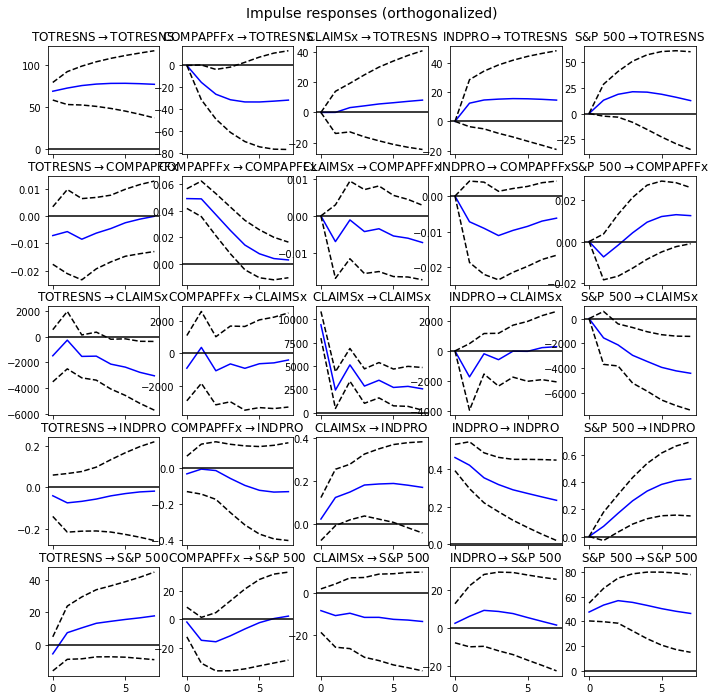

The function plots the Forecast Error Variance Decomposition
FEVD for TOTRESNS
      TOTRESNS  COMPAPFFx   CLAIMSx    INDPRO   S&P 500
0     1.000000   0.000000  0.000000  0.000000  0.000000
1     0.947530   0.022221  0.000000  0.014544  0.015704
2     0.897182   0.052226  0.000583  0.020873  0.029136
3     0.862526   0.074787  0.001158  0.023675  0.037854
4     0.841154   0.090015  0.001825  0.025298  0.041708
5     0.829558   0.099556  0.002480  0.026240  0.042165
6     0.823943   0.105482  0.003191  0.026770  0.040614
7     0.821731   0.109261  0.003954  0.027004  0.038050
8     0.821147   0.111893  0.004792  0.027055  0.035113
9     0.821139   0.113964  0.005709  0.027000  0.032188
10    0.821075   0.115805  0.006713  0.026901  0.029505
11    0.820611   0.117581  0.007809  0.026800  0.027200

FEVD for COMPAPFFx
      TOTRESNS  COMPAPFFx   CLAIMSx    INDPRO   S&P 500
0     0.020436   0.979564  0.000000  0.000000  0.000000
1     0.016294   0.952862  0.009590  0.010340  0.010915
2    

{'INDPRO': 1, 'CLAIMSx': 2, 'TOTRESNS': 4, 'S&P 500': 1, 'COMPAPFFx': 5}

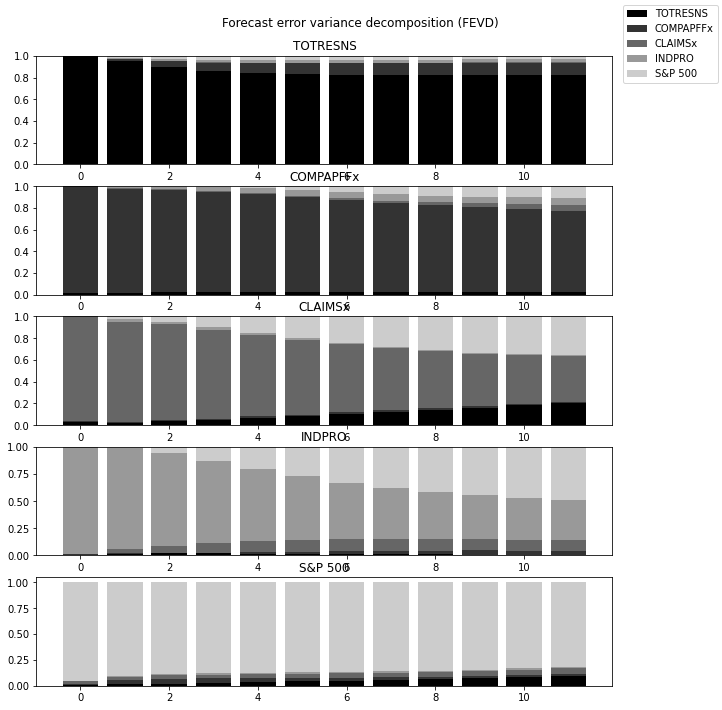

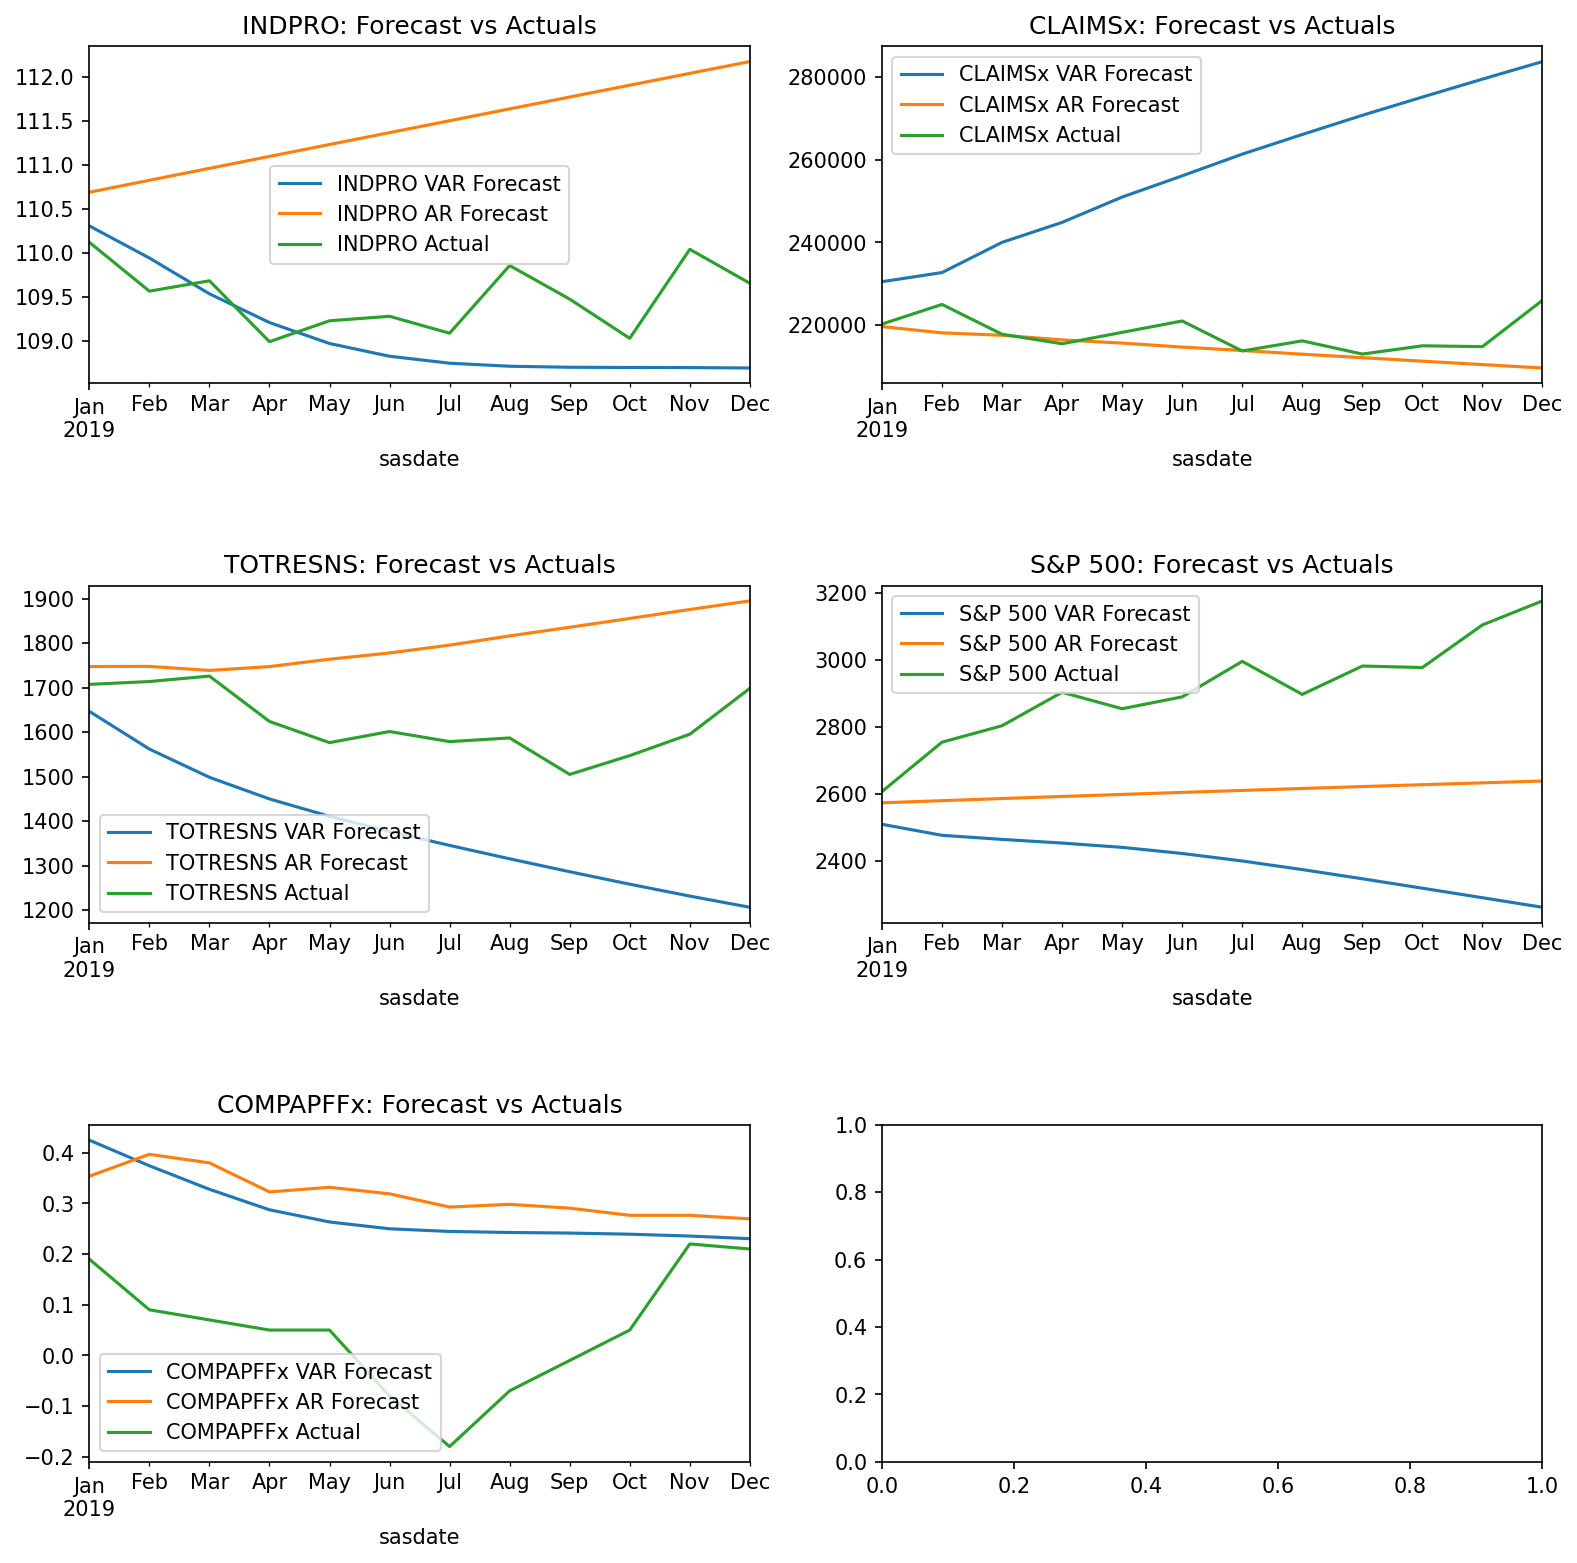

In [24]:
# Figure 21
variables10 = ["TOTRESNS","COMPAPFFx","CLAIMSx","INDPRO","S&P 500"]
cointegration_test(USA[variables10],alpha = 0.05)
code = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in variables10}
coin_evaluate_plot(USA[variables10],code,num=12)